In [103]:
import csv
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as sk
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score

from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, Input, Dropout
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Nadam

In [104]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [105]:
RANDOM_SEED = 42
NUM_CLASSES = 4

<h1>1 Ucitavanje skupa podataka</h1>

In [106]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

In [107]:
train_set = 'C:\\Users\\Ana\\Downloads\\keypoints_train.csv'
val_set = 'C:\\Users\\Ana\\Downloads\\keypoints_val.csv'
test_set = 'C:\\Users\\Ana\\Downloads\\keypoints_test.csv'

In [108]:
X_train = np.loadtxt(train_set, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_train = np.loadtxt(train_set, delimiter=',', dtype='int32', usecols=(0))

In [109]:
X_val = np.loadtxt(val_set, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_val = np.loadtxt(val_set, delimiter=',', dtype='int32', usecols=(0))

In [110]:
X_test = np.loadtxt(test_set, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_test = np.loadtxt(test_set, delimiter=',', dtype='int32', usecols=(0))

<h1>2 Funkcije za evaluaciju</h1>

In [119]:
def confusionmat(y, y_hat):
    y_pred = np.argmax(y_hat, axis=1)  
    cm = confusion_matrix(y, y_pred)
    accu = accuracy_score(y, y_pred)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", square=True)

    # Set labels, title, and accuracy
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.text(0, -0.5, "Accuracy: {:.2f}".format(accu), fontsize=12, ha="center")

    # Set x-axis and y-axis tick labels
    classes = np.unique(y)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Show the plot
    plt.show()

In [112]:
def confusionmat(y,y_hat):
    from sklearn.metrics import confusion_matrix,accuracy_score
    cm = confusion_matrix(y, y_hat)
    accu=accuracy_score(y,y_hat)
    print(cm,"\n")
    print("The accuracy is",accu)

In [113]:
def learningcurve(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(5, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [114]:
# za eventualno uporedjivanje svih modela
def bar_plot(models):
    colors = []
    x = []
    for i in range(len(models)):
        colors.append(plt.cm.Set2(i))
        x.append(models[i][1])
      
    plt.bar(range(len(x)), x, color=colors)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar plot of f-measure for every model')
    for i, val in enumerate(x):
        plt.text(i, val + 0.02, f"{val:.3f}", ha='center')   
    plt.ylim(0, max(x) + 0.1)
    tick_labels = ['Model {}'.format(i+1) for i in range(len(x))]
    plt.xticks(range(len(x)), tick_labels)
    plt.show()

In [115]:
def evaluation_function(model, X_test, y_test, history, epoch):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    test_results = model.evaluate(X_test, y_test)
    print("For epoch = {0}, the model test accuracy is {1}.".format(epoch,test_results[1]))
    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print("F1 score:", f1)
    confusionmat(y_test,y_pred)
    learningcurve(history)

In [116]:
def neural_network(nodes, activation_functions, optimizer, callbacks, epochs, model_save_path):
    model = Sequential()
    model.add(Input((21 * 2, )))
    for node, func in zip(nodes, activation_functions):
        model.add(Dense(node,activation=func))
    model.add(Dense(NUM_CLASSES,activation="softmax"))
    model.compile(optimizer = optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history=model.fit(X_train, 
                      y_train, 
                      batch_size = 128, 
                      epochs=epochs,
                      validation_data=(X_val, y_val), 
                      verbose=0, 
                      callbacks=callbacks)
    
    model.save(model_save_path)
    evaluation_function(model, X_test, y_test, history, epochs)

<h1>3 Izgradnja modela</h1>

In [89]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=0, save_weights_only=False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0)

callbacks_cp_es=[cp_callback, es_callback]

3/3 [==============================] - 0s 7ms/step - loss: 0.2319 - accuracy: 0.9375
For epoch = 200, the model test accuracy is 0.9375.
F1 score: 0.9375849299275277


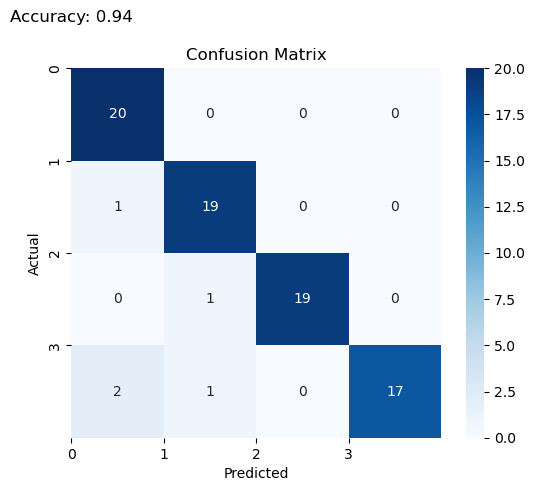

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


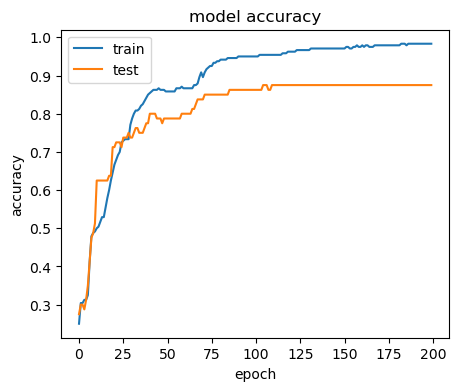

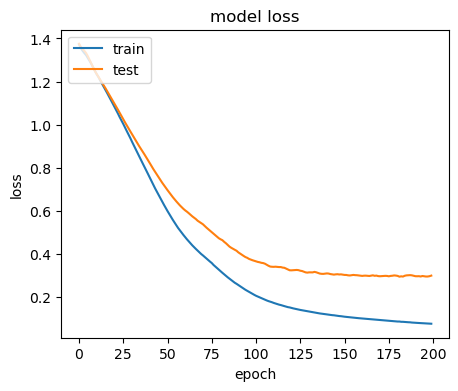

In [91]:
neural_network(nodes=[100, 10],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=cp_callback,
               epochs=200,
               model_save_path=model_save_path
              )

<h2>4 Isprobavanje razlicitih aktivacionih funkcija</h2>

In [27]:
functions = ['tanh', 'sigmoid', 'softmax', 'relu']

tanh
3/3 [==============================] - 0s 6ms/step - loss: 0.3670 - accuracy: 0.8375
For epoch = 200, the model test accuracy is 0.8374999761581421.
F1 score: 0.8355047355047354


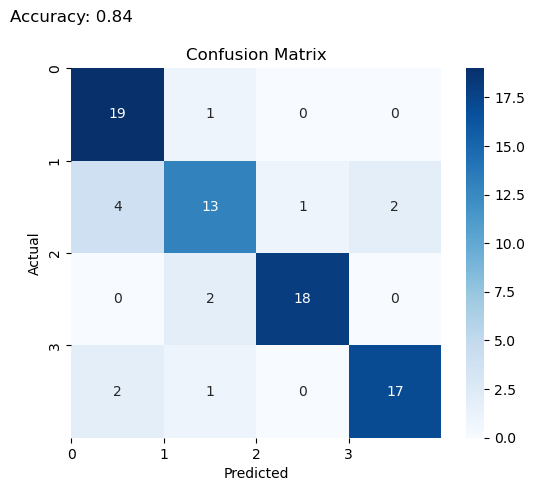

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


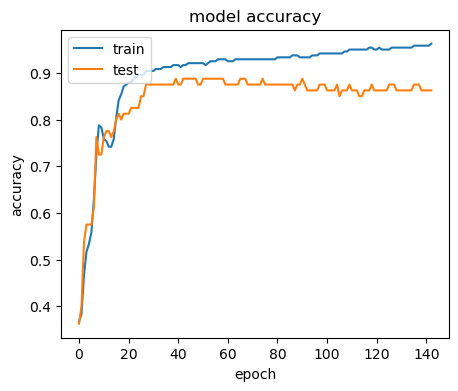

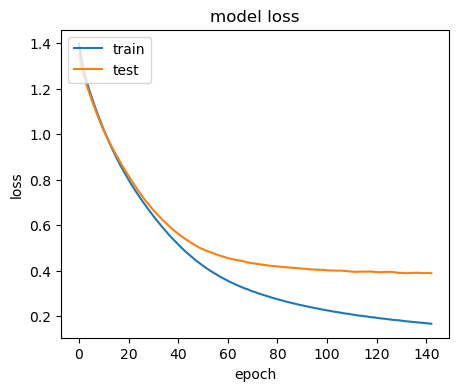

sigmoid
3/3 [==============================] - 0s 6ms/step - loss: 0.6715 - accuracy: 0.8000
For epoch = 200, the model test accuracy is 0.800000011920929.
F1 score: 0.7919843985989267


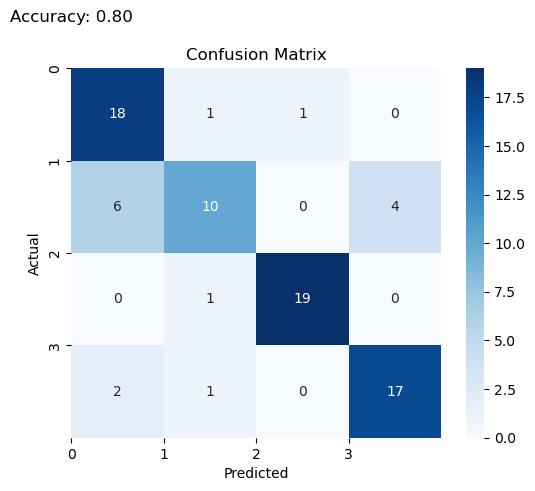

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


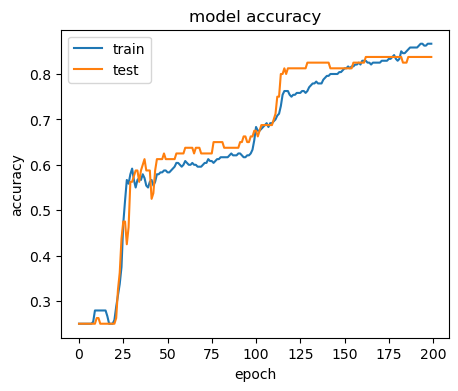

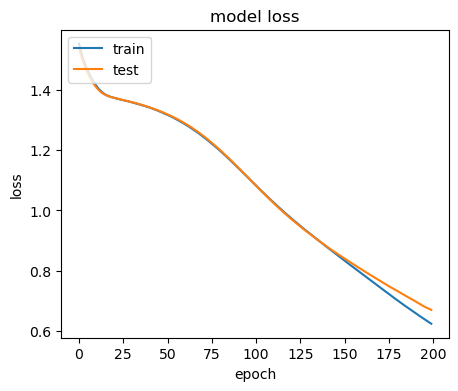

softmax
3/3 [==============================] - 0s 9ms/step - loss: 1.2002 - accuracy: 0.5375
For epoch = 200, the model test accuracy is 0.5375000238418579.
F1 score: 0.4882620376746017


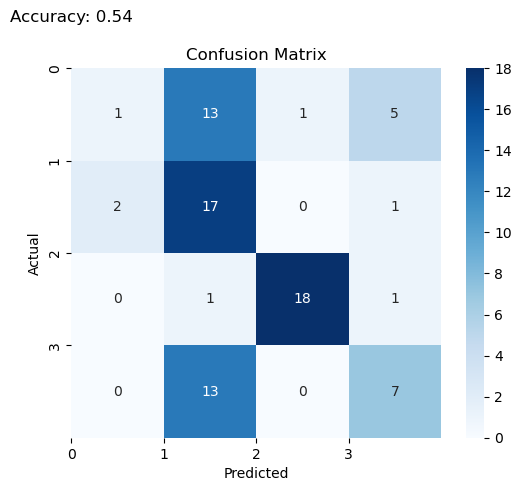

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


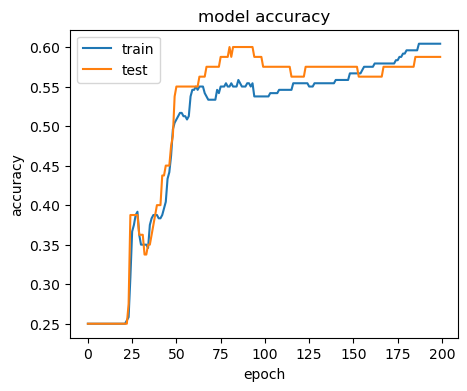

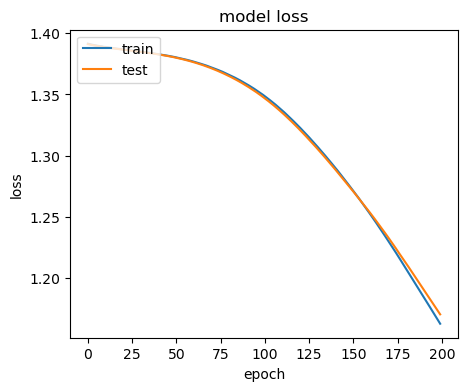

relu
3/3 [==============================] - 0s 5ms/step - loss: 0.2378 - accuracy: 0.9375
For epoch = 200, the model test accuracy is 0.9375.
F1 score: 0.9377716877716878


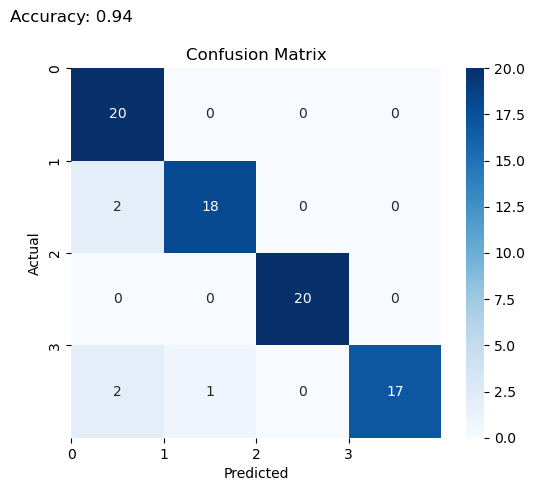

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


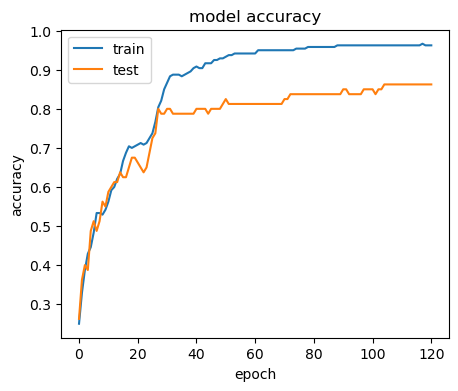

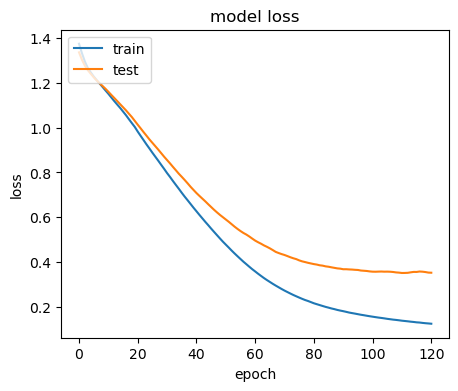

In [79]:
for function in functions:
    print(function)
    neural_network(nodes=[100, 10],
               activation_functions=[function, function],
               optimizer="adam",
               callbacks=es_callback,
               epochs=200,
               model_save_path=model_save_path
              )

<h2>5 Podesavanje learning rate-a</h2>

<h4>Reduce Learning Rate on Plateau - najbolji model</h4>

In [94]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_cp_plateau = [reduce_lr, cp_callback]

3/3 [==============================] - 0s 5ms/step - loss: 0.1847 - accuracy: 0.9500
For epoch = 200, the model test accuracy is 0.949999988079071.
F1 score: 0.9504899883877853


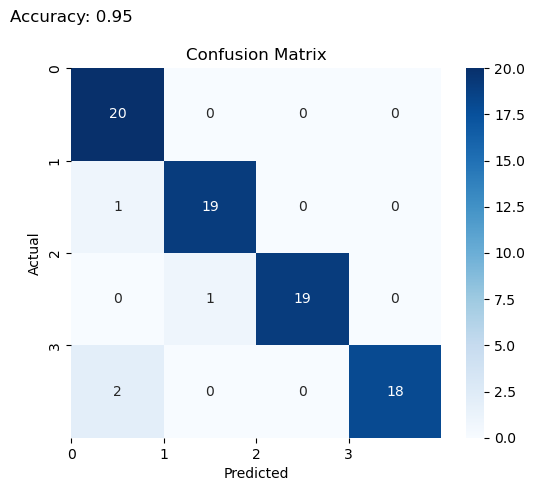

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


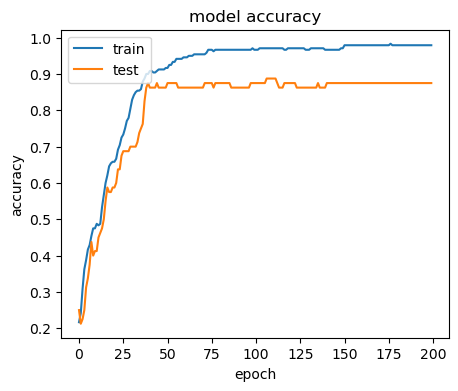

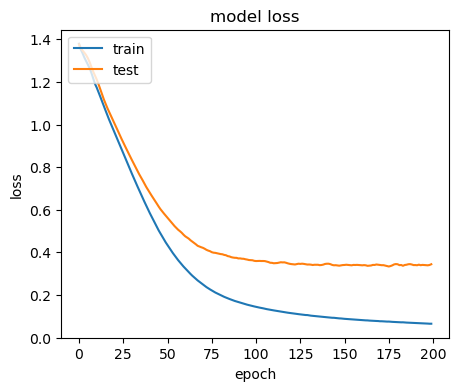

In [98]:
neural_network(nodes=[100, 10],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=callbacks_cp_plateau,
               epochs=200,
               model_save_path=model_save_path
              )

3/3 [==============================] - 0s 6ms/step - loss: 0.1692 - accuracy: 0.9250
For epoch = 200, the model test accuracy is 0.925000011920929.
F1 score: 0.9262940572151098


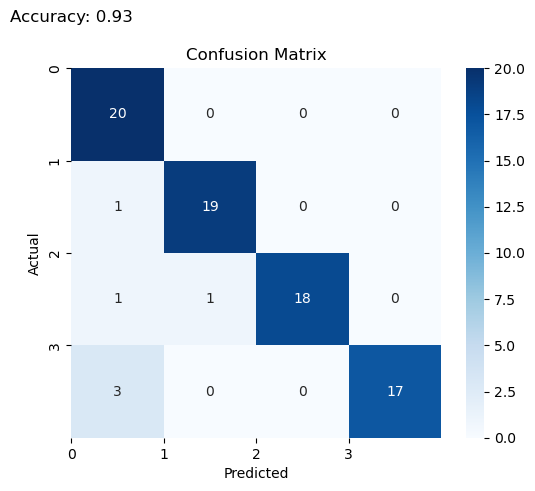

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


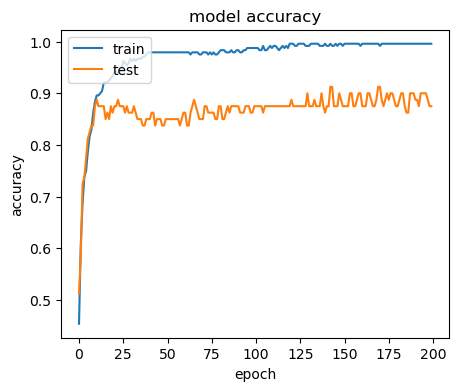

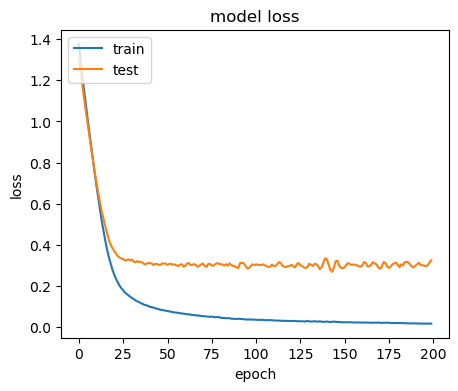

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [reduce_lr, cp_callback]

neural_network(nodes=[100, 500],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=callbacks_list,
               epochs=200,
               model_save_path=model_save_path
              )

3/3 [==============================] - 0s 6ms/step - loss: 0.2784 - accuracy: 0.8875
For epoch = 200, the model test accuracy is 0.887499988079071.
F1 score: 0.8893507638072856


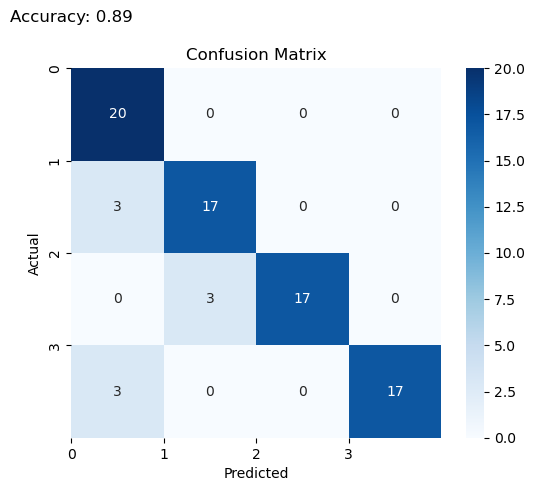

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


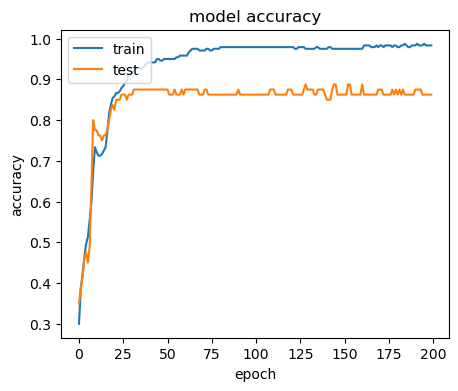

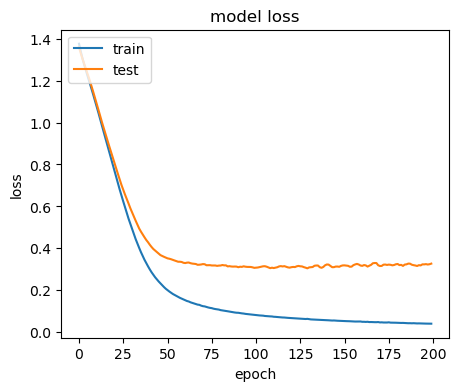

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
callbacks_list = [reduce_lr, cp_callback]

neural_network(nodes=[64, 64],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=callbacks_list,
               epochs=200,
               model_save_path=model_save_path
              )

<h4>Exponential learning rate scheduler</h4>

3/3 [==============================] - 0s 5ms/step - loss: 1.3866 - accuracy: 0.2500
For epoch = 200, the model test accuracy is 0.25.
F1 score: 0.1


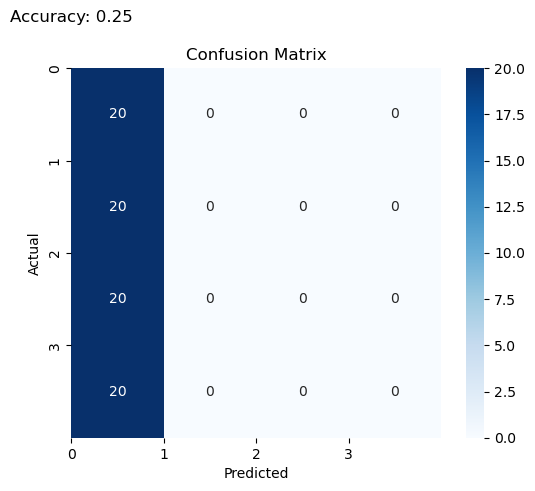

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


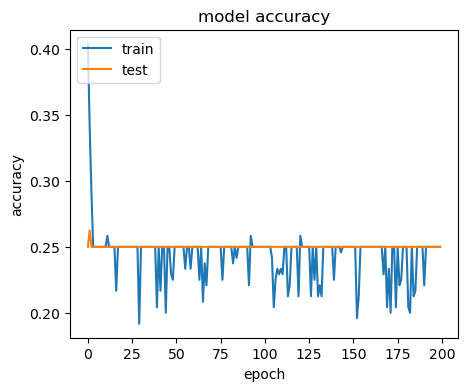

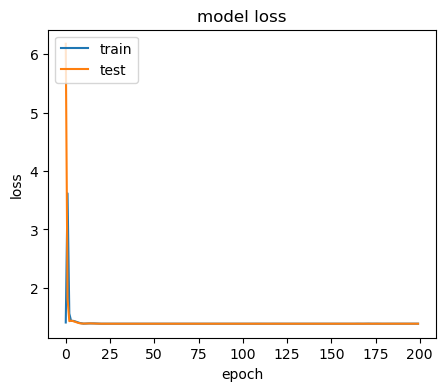

In [20]:
learning_rate = 0.1
decay_rate = learning_rate / 1000

def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [lr_rate, cp_callback]

neural_network(nodes=[100, 10],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=callbacks_list,
               epochs=200,
               model_save_path=model_save_path
              )

<h1>6 Rešavanje overfitting-a</h1>

<h2>6.1 Early stopping</h2>

In [117]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.01)

3/3 [==============================] - 0s 5ms/step - loss: 0.2819 - accuracy: 0.9125
For epoch = 200, the model test accuracy is 0.9125000238418579.
F1 score: 0.9125966504463087


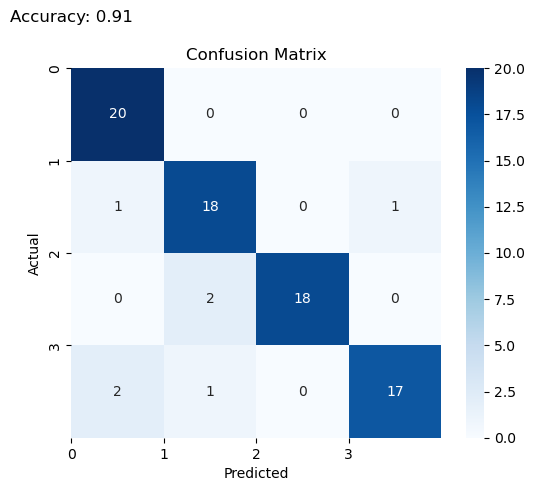

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


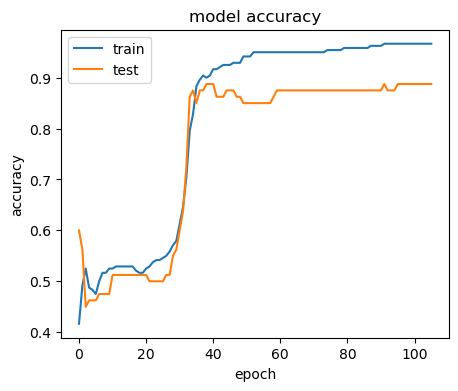

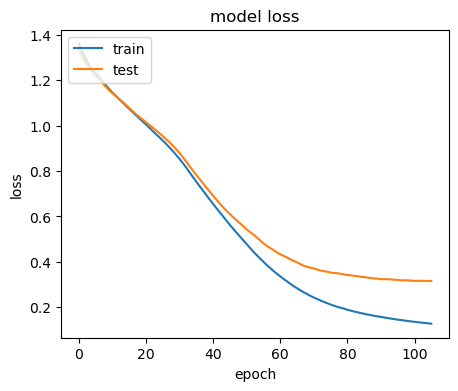

In [120]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

callbacks_cp_es_lr = [reduce_lr, cp_callback, es_callback]

neural_network(nodes=[100, 10],
               activation_functions=["relu", "relu"],
               optimizer="adam",
               callbacks=callbacks_cp_es_lr,
               epochs=200,
               model_save_path=model_save_path
              )

<h2>6.2 Early stopping + Drop out</h2>

3/3 [==============================] - 0s 6ms/step - loss: 0.3339 - accuracy: 0.9125
For epoch = 200, the model test accuracy is 0.9125000238418579.
F1 score: 0.9121625559814055


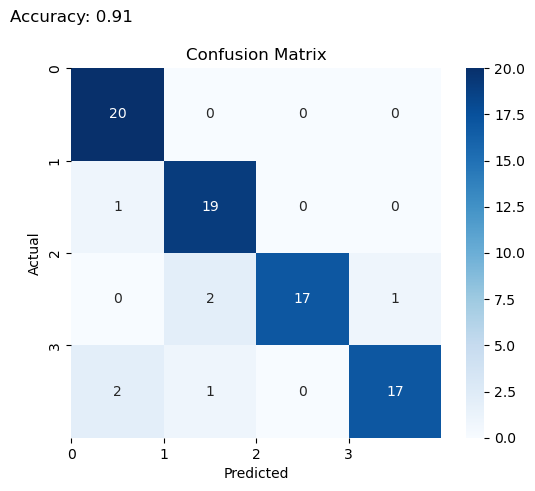

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


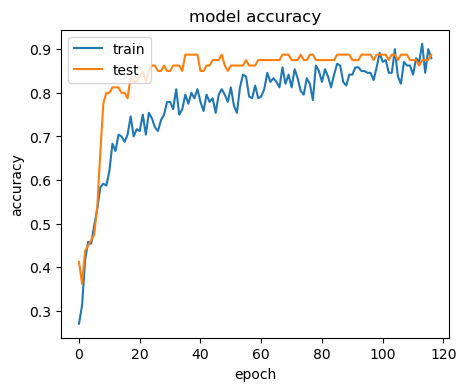

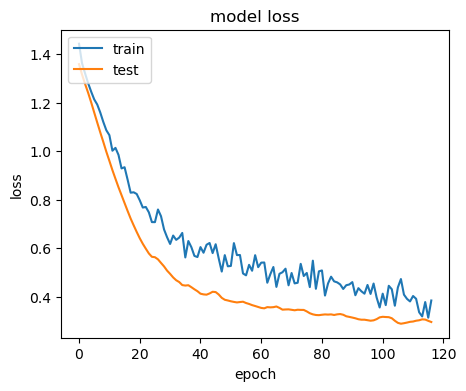

In [69]:
model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dropout(0.2),
    Dense(150, activation='relu'),
    Dropout(0.4),
    Dense(100, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history=model.fit(X_train, 
                  y_train, 
                  batch_size = 128, 
                  epochs=200,
                  validation_data=(X_val, y_val), 
                  verbose=0, 
                  callbacks)

epochs=200
model.save(model_save_path)
evaluation_function(model, X_test, y_test, history, epochs)

<h2>6.3 Regularizacija L1</h2>

3/3 [==============================] - 0s 5ms/step - loss: 0.8937 - accuracy: 0.8250
For epoch = 200, the model test accuracy is 0.824999988079071.
F1 score: 0.827212918660287


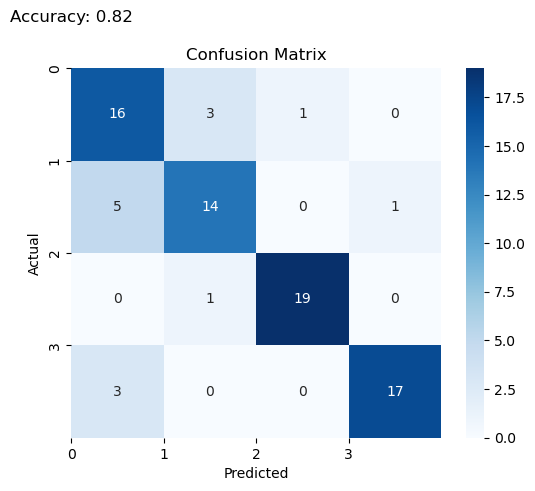

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


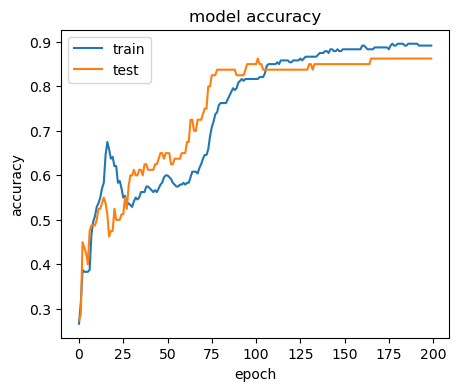

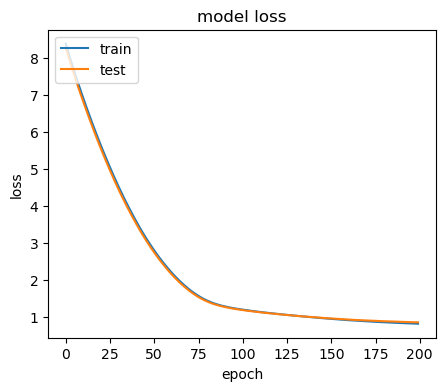

In [70]:
model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dense(150, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history=model.fit(X_train, 
                  y_train, 
                  batch_size = 128, 
                  epochs=200,
                  validation_data=(X_val, y_val), 
                  verbose=0, 
                  callbacks=callbacks)

epochs=200
model.save(model_save_path)
evaluation_function(model, X_test, y_test, history, epochs)

<h2>6.4 Regularizacija L2</h2>

3/3 [==============================] - 0s 5ms/step - loss: 0.6048 - accuracy: 0.9000
For epoch = 200, the model test accuracy is 0.8999999761581421.
F1 score: 0.8993375046006626


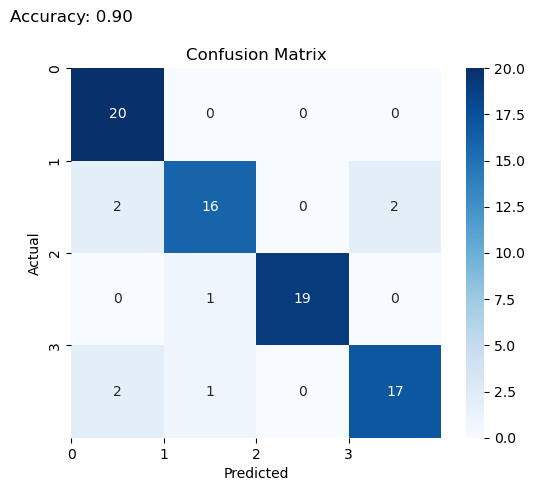

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


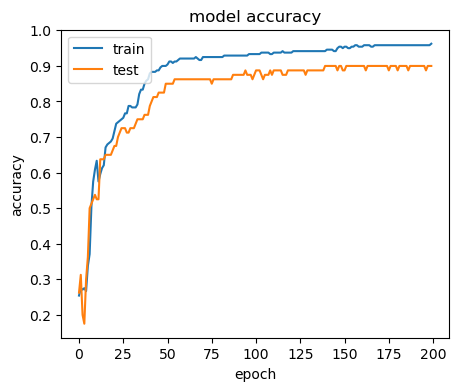

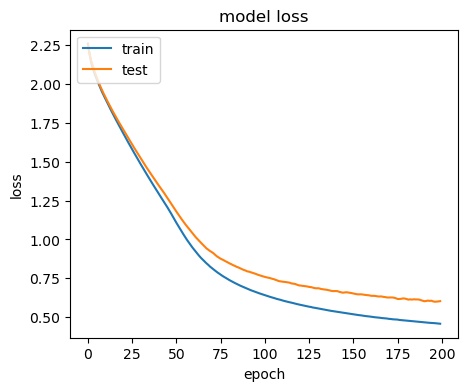

In [121]:
model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history=model.fit(X_train, 
                  y_train, 
                  batch_size = 128, 
                  epochs=200,
                  validation_data=(X_val, y_val), 
                  verbose=0, 
                  callbacks=cp_callback)

epochs=200
model.save(model_save_path)
evaluation_function(model, X_test, y_test, history, epochs)

<h3>Regularizacija L2 + podesavanje learning rate-a</h3>

3/3 [==============================] - 0s 5ms/step - loss: 0.5554 - accuracy: 0.9375
For epoch = 200, the model test accuracy is 0.9375.
F1 score: 0.9375849299275277


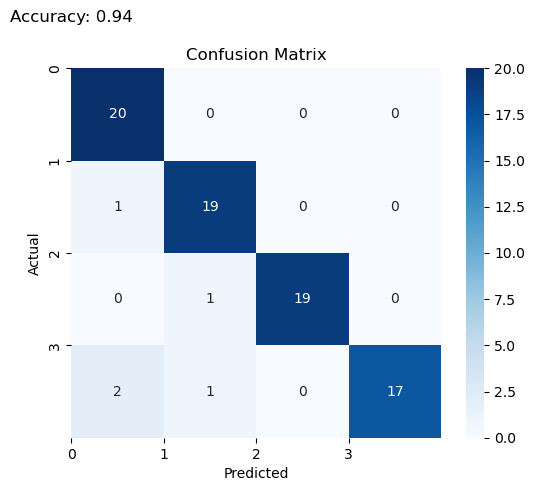

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


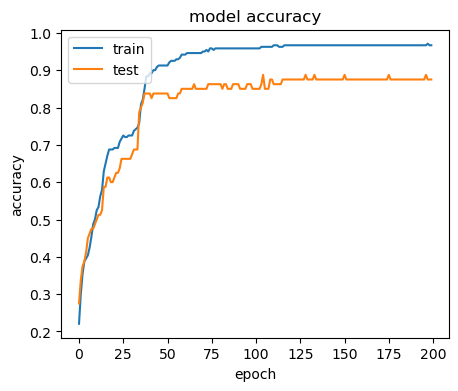

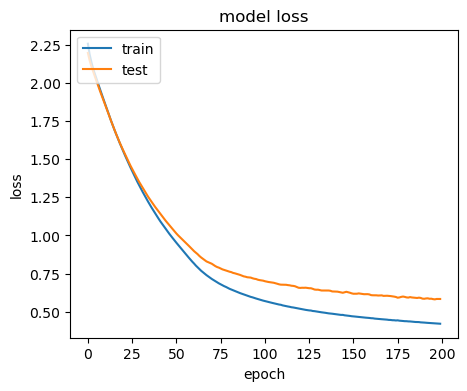

In [88]:
callbacks_list = [reduce_lr, cp_callback]

model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history=model.fit(X_train, 
                  y_train, 
                  batch_size = 128, 
                  epochs=200,
                  validation_data=(X_val, y_val), 
                  verbose=0, 
                  callbacks=callbacks_list)

epochs=200
model.save(model_save_path)
evaluation_function(model, X_test, y_test, history, epochs)

<h3>Regularizacija L2 + podesavanje learning rate-a + Dropout</h3>

3/3 [==============================] - 0s 9ms/step - loss: 0.6451 - accuracy: 0.9250
For epoch = 200, the model test accuracy is 0.925000011920929.
F1 score: 0.9247917723975281


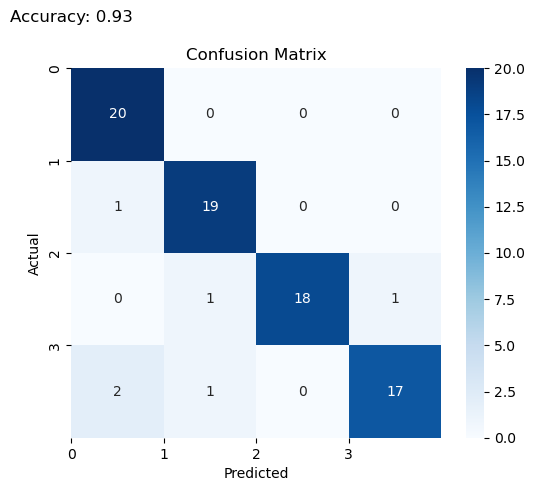

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


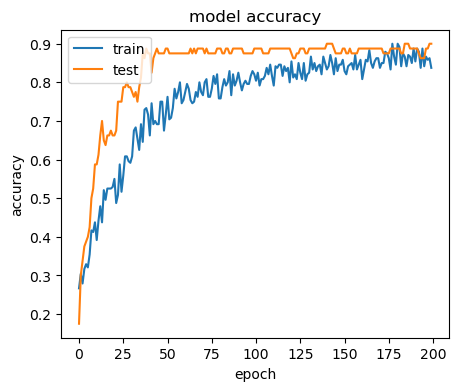

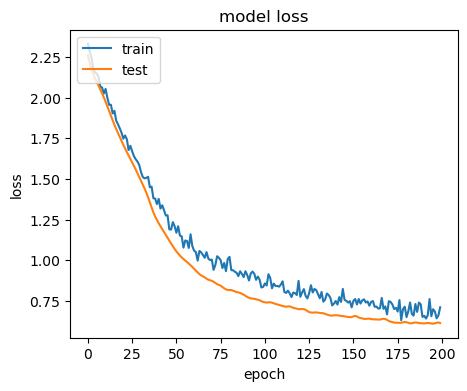

In [85]:
callbacks_list = [reduce_lr, cp_callback]

model = tf.keras.models.Sequential([
    Input((21 * 2, )),
    Dropout(0.2),
    Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
history=model.fit(X_train, 
                  y_train, 
                  batch_size = 128, 
                  epochs=200,
                  validation_data=(X_val, y_val), 
                  verbose=0, 
                  callbacks=callbacks_list)

epochs=200
model.save(model_save_path)
evaluation_function(model, X_test, y_test, history, epochs)

<h1>7 Podesavanje optimizer-a</h1>

Optimizer:  sgd
[[20  0  0  0]
 [ 3 13  0  4]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.8625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


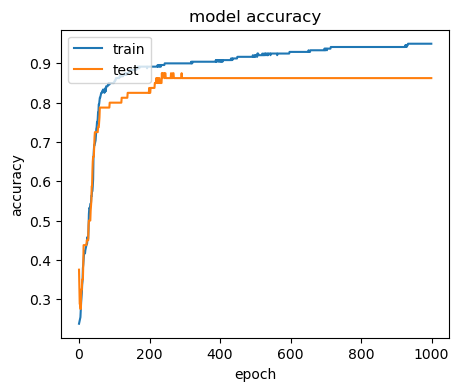

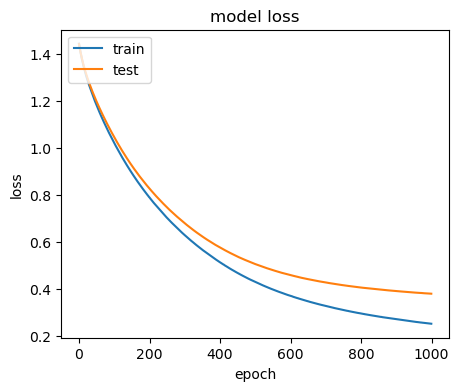

Optimizer:  rmsprop
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


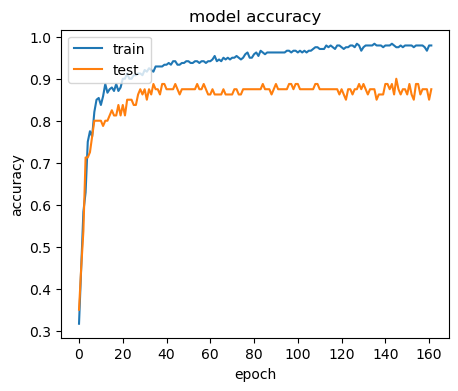

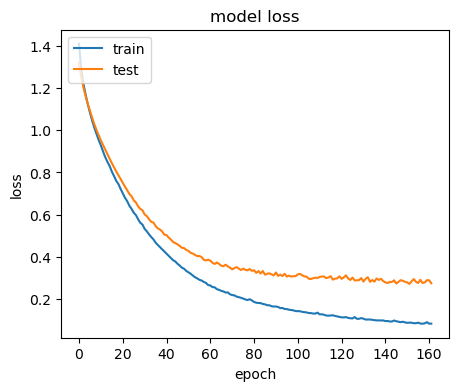

Optimizer:  adam
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


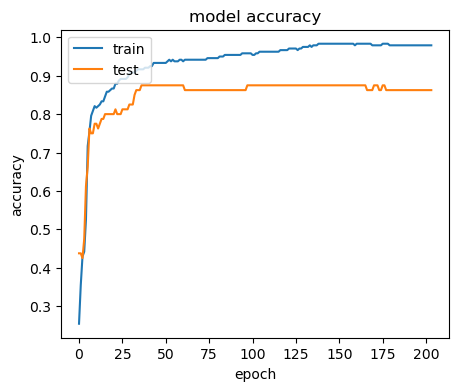

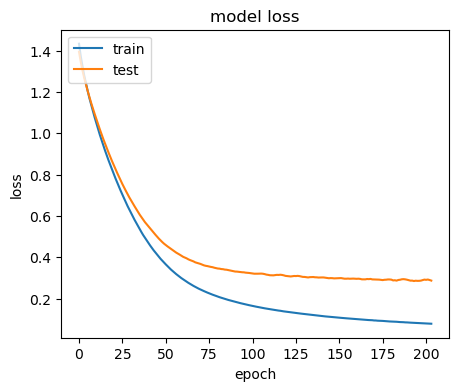

Optimizer:  adagrad
[[18  1  1  0]
 [ 3 12  0  5]
 [ 0  1 18  1]
 [ 2  2  0 16]] 

The accuracy is 0.8
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


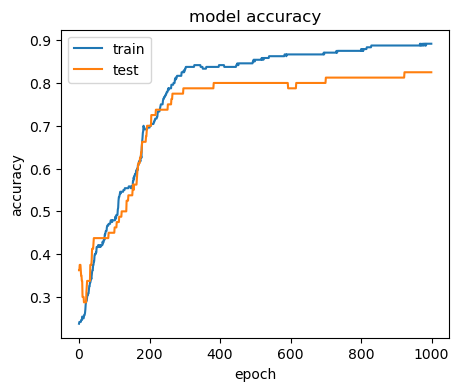

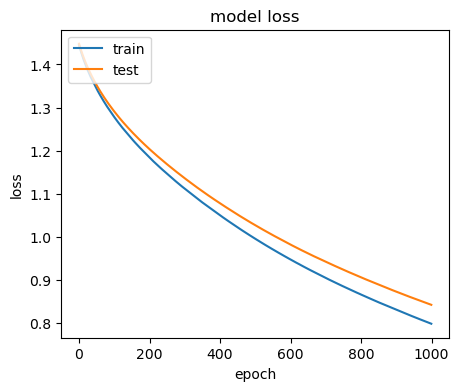

Optimizer:  adadelta
[[18  2  0  0]
 [13  7  0  0]
 [10  7  3  0]
 [12  8  0  0]] 

The accuracy is 0.35
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


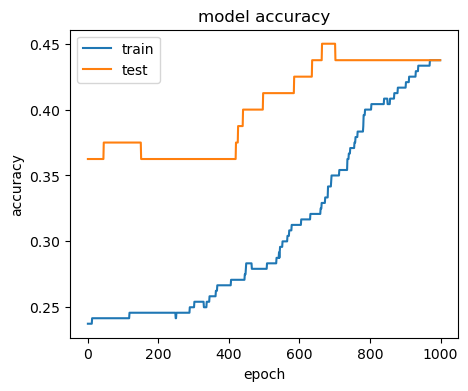

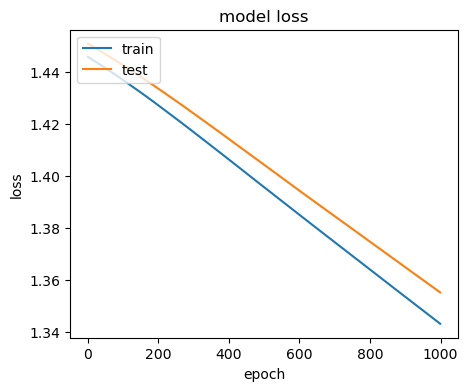

Optimizer:  nadam
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


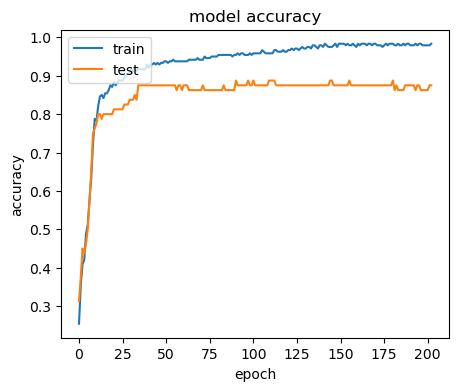

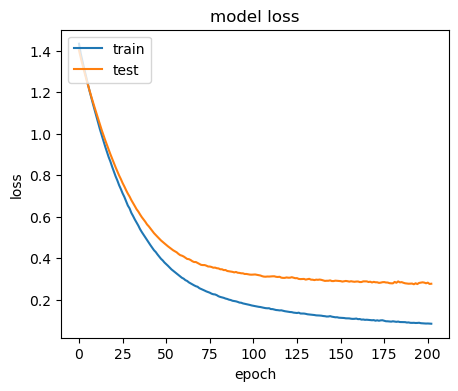

In [55]:
optimizers = ['sgd', 'rmsprop', 'adam', 'adagrad', 'adadelta', 'nadam']

for optimizer in optimizers:
    print("Optimizer: ", optimizer)
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    
    #Model building
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    # Model compilation
    model.compile(
        optimizer = optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Model training
    history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback], verbose=0)
    
    # Evaluation
    Y_pred = model(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    confusionmat(y_test,y_pred)
    learningcurve(history)

Nekoliko optimizer-a je dalo istu tacnost (0.8125), pa je za dalja istrazivanja uzet optimizer adam

<h1>8 Razliciti brojevi epoha</h1>

Epochs:  100
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  1 18  1]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


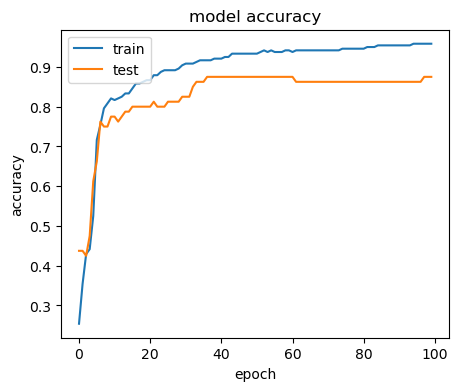

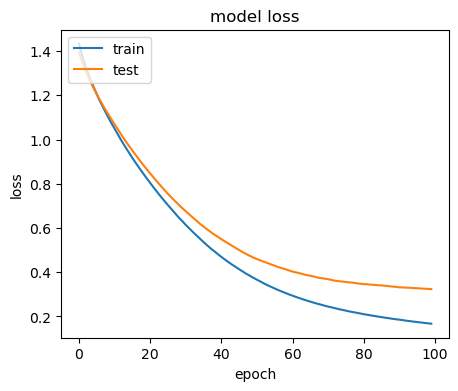

Epochs:  200
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


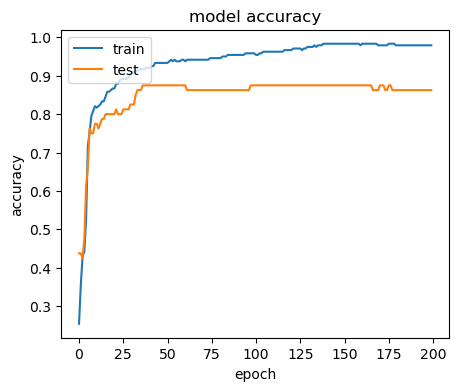

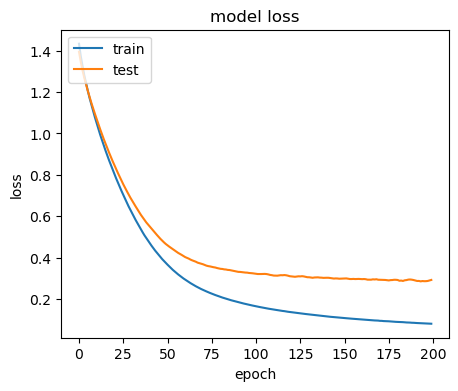

Epochs:  250
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


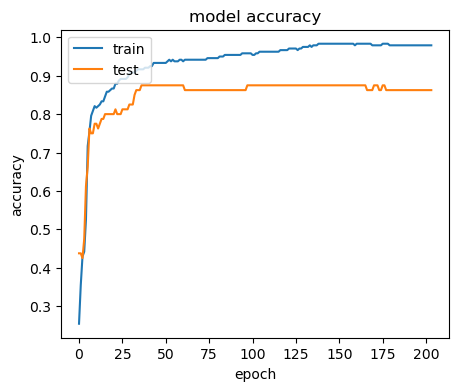

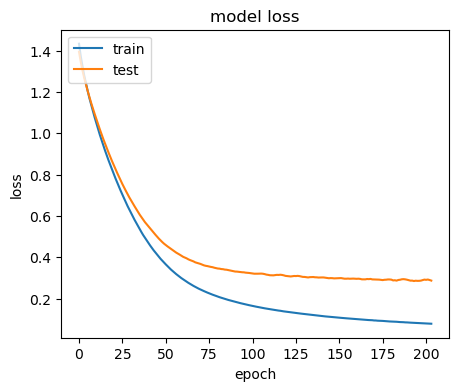

Epochs:  500
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


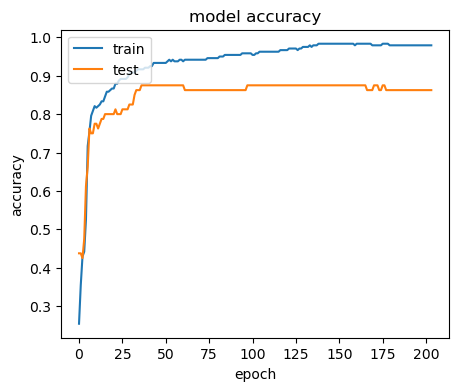

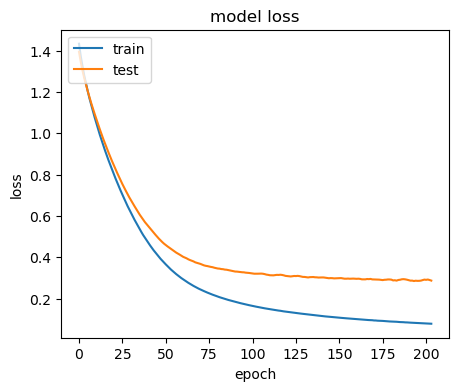

Epochs:  1000
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


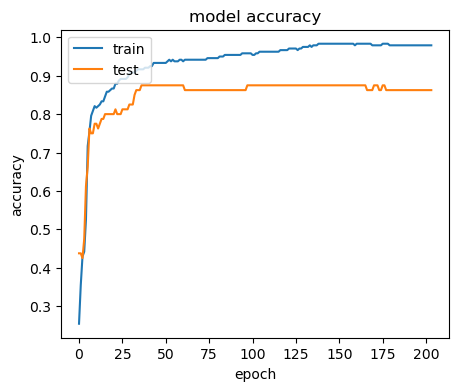

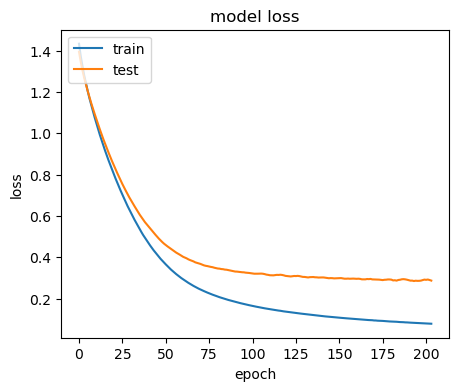

Epochs:  5000
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


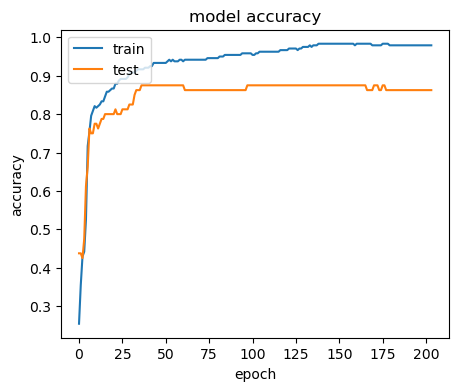

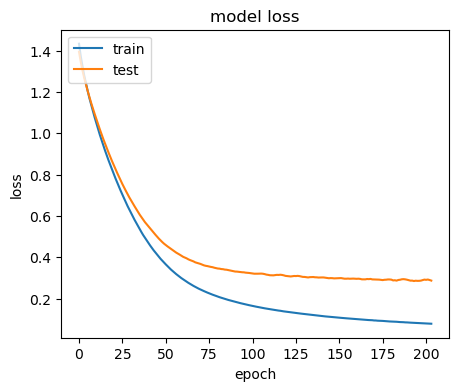

In [58]:
epochs = [100, 200, 250, 500, 1000, 5000]

for num_of_epochs in epochs:
    print("Epochs: ", num_of_epochs)
    
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #Model building
    model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Model compilation
    model.compile(
        optimizer = 'adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Model training
    history = model.fit(X_train, y_train, epochs = num_of_epochs, batch_size=128, validation_data=(X_val, y_val),
    callbacks=[cp_callback, es_callback], verbose=0)
    
    # Evaluation
    Y_pred = model(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    confusionmat(y_test,y_pred)
    learningcurve(history)

<h1>9 Razlicit broj slojeva</h1>

[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


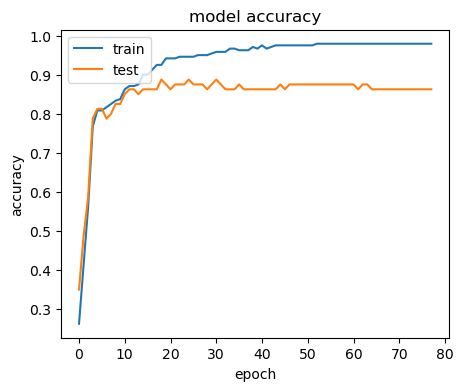

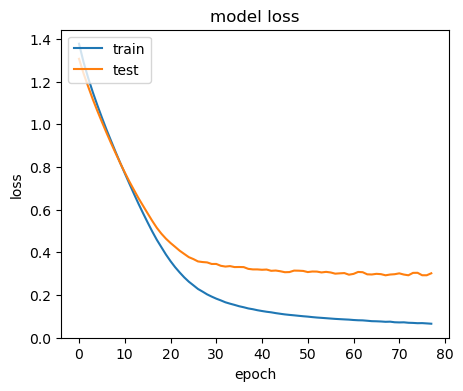

In [59]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#Model building
model = tf.keras.models.Sequential([
tf.keras.layers.Input((21 * 2, )),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history = model.fit(X_train, y_train, epochs = 200, batch_size=128, validation_data=(X_val, y_val),
callbacks=[cp_callback, es_callback], verbose=0)

# Evaluation
Y_pred = model(X_test)
y_pred = np.argmax(Y_pred, axis=1)
confusionmat(y_test,y_pred)
learningcurve(history)

[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


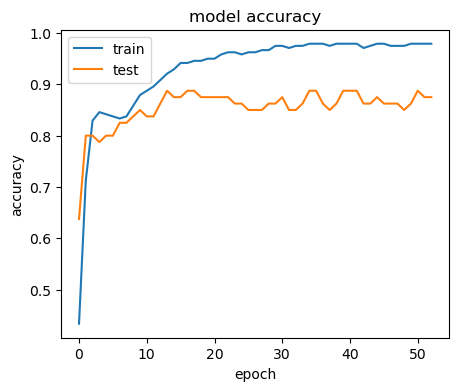

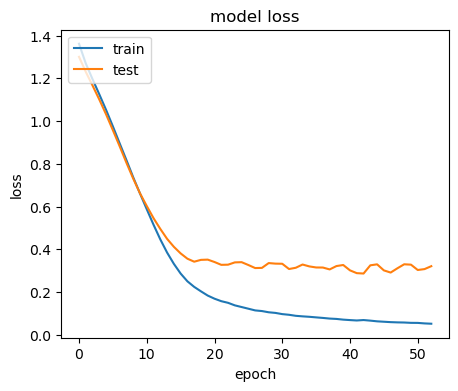

In [60]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#Model building
model = tf.keras.models.Sequential([
tf.keras.layers.Input((21 * 2, )),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history = model.fit(X_train, y_train, epochs = 200, batch_size=128, validation_data=(X_val, y_val),
callbacks=[cp_callback, es_callback], verbose=0)

# Evaluation
Y_pred = model(X_test)
y_pred = np.argmax(Y_pred, axis=1)
confusionmat(y_test,y_pred)
learningcurve(history)

[[18  1  0  1]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


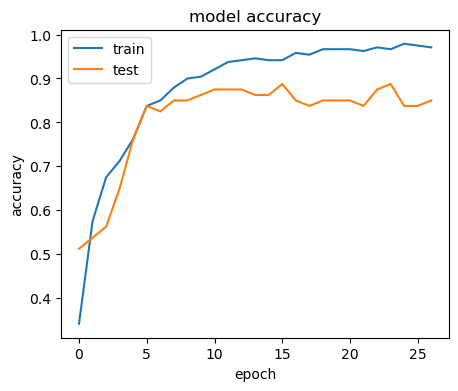

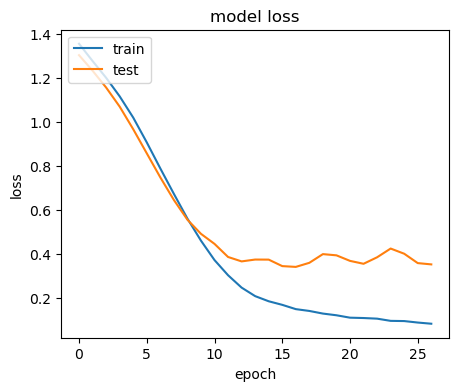

In [61]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#Model building
model = tf.keras.models.Sequential([
tf.keras.layers.Input((21 * 2, )),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(150, activation='relu'),
tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Model compilation
model.compile(
    optimizer = 'adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training
history = model.fit(X_train, y_train, epochs = 200, batch_size=128, validation_data=(X_val, y_val),
callbacks=[cp_callback, es_callback], verbose=0)

# Evaluation
Y_pred = model(X_test)
y_pred = np.argmax(Y_pred, axis=1)
confusionmat(y_test,y_pred)
learningcurve(history)

<h1>10 Razlicit broj neurona</h1>

First layer: 8, Second layer: 8
[[19  1  0  0]
 [ 3 17  0  0]
 [ 1  2 17  0]
 [ 2  1  0 17]] 

The accuracy is 0.875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


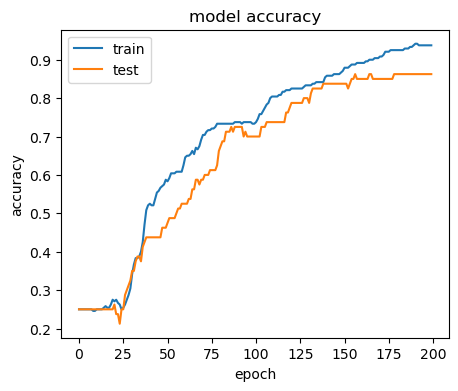

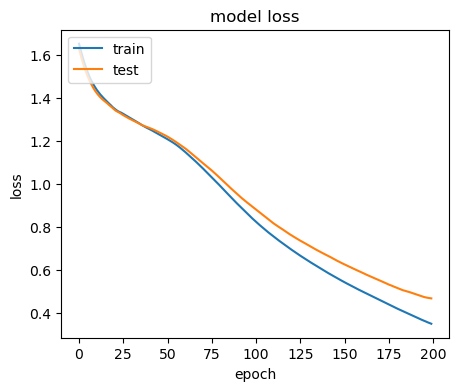

First layer: 8, Second layer: 16
[[17  2  0  1]
 [ 2 18  0  0]
 [ 0  1 19  0]
 [ 3  1  0 16]] 

The accuracy is 0.875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


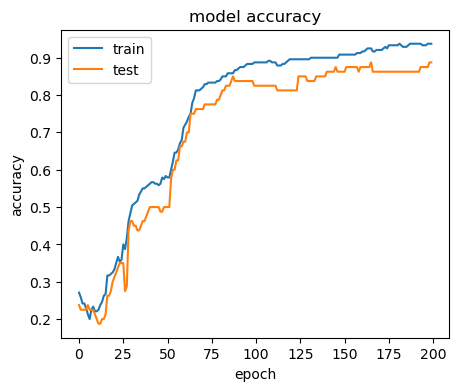

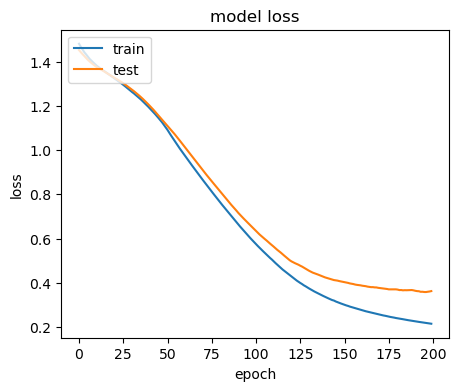

First layer: 8, Second layer: 32
[[18  1  0  1]
 [ 3 15  0  2]
 [ 0  2 17  1]
 [ 5  0  0 15]] 

The accuracy is 0.8125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


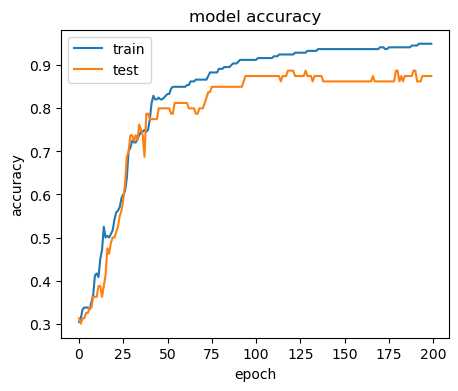

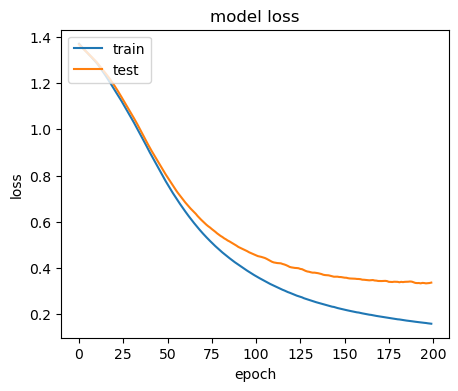

First layer: 8, Second layer: 64
[[19  1  0  0]
 [ 3 16  0  1]
 [ 0  0 20  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


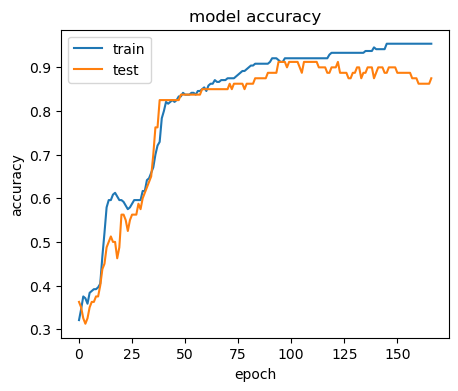

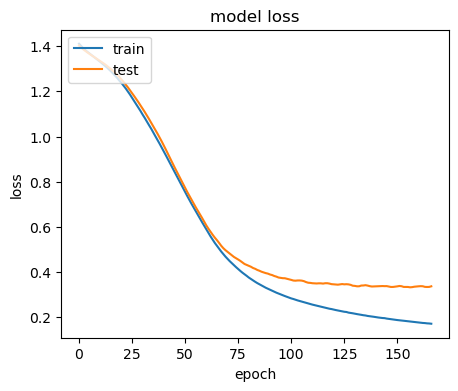

First layer: 8, Second layer: 128
[[19  1  0  0]
 [ 2 16  0  2]
 [ 0  0 20  0]
 [ 4  1  0 15]] 

The accuracy is 0.875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


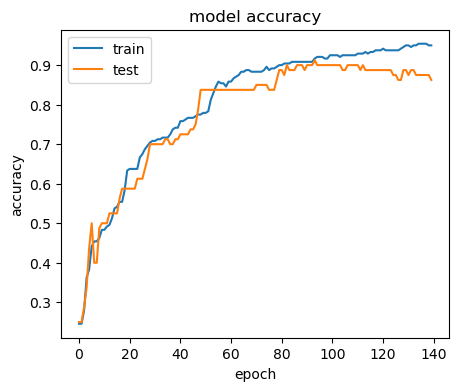

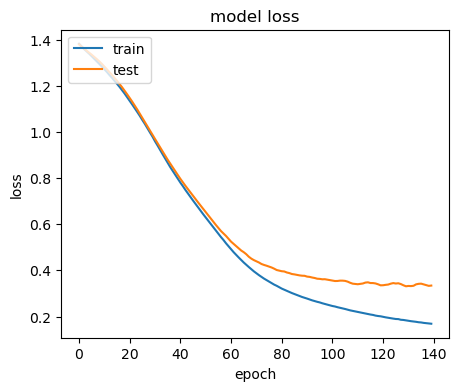

First layer: 8, Second layer: 256
[[19  0  0  1]
 [ 3 15  0  2]
 [ 0  1 19  0]
 [ 4  0  0 16]] 

The accuracy is 0.8625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


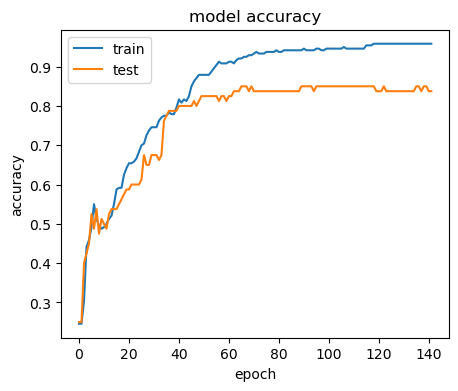

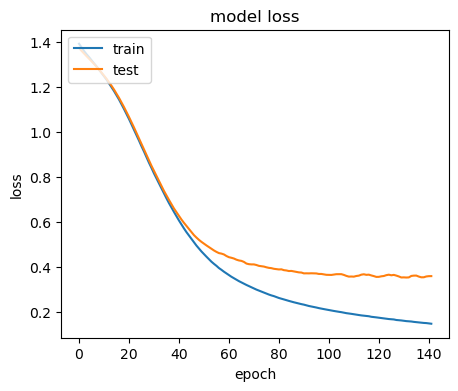

First layer: 8, Second layer: 512
[[19  1  0  0]
 [ 2 17  0  1]
 [ 0  1 19  0]
 [ 3  1  0 16]] 

The accuracy is 0.8875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


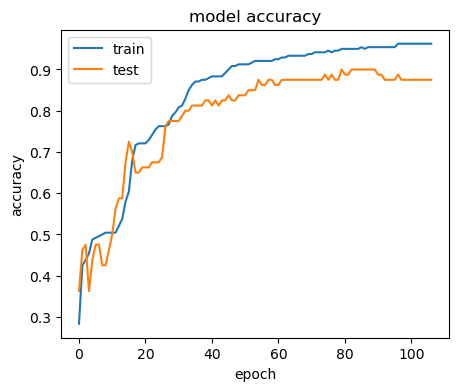

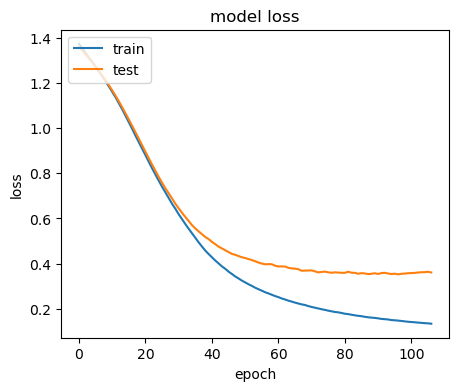

First layer: 16, Second layer: 8
[[19  0  0  1]
 [ 2 17  0  1]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


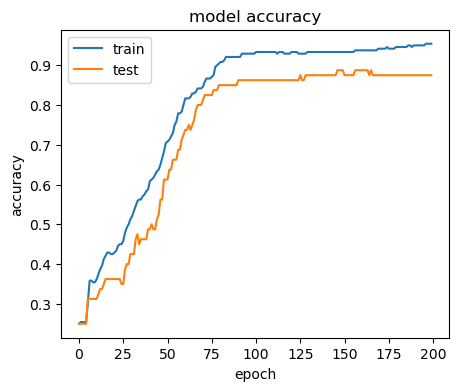

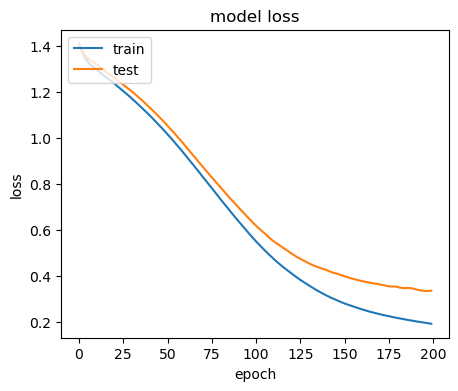

First layer: 16, Second layer: 16
[[18  1  0  1]
 [ 2 18  0  0]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


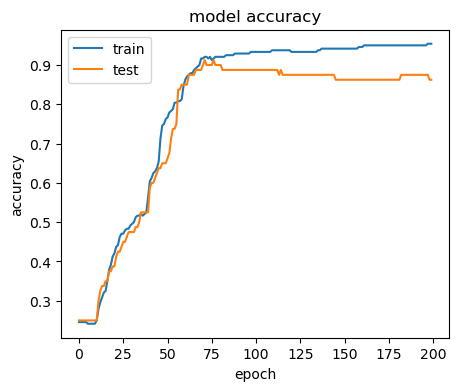

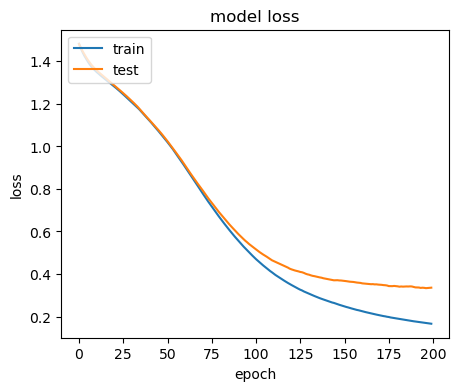

First layer: 16, Second layer: 32
[[19  0  0  1]
 [ 4 15  0  1]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


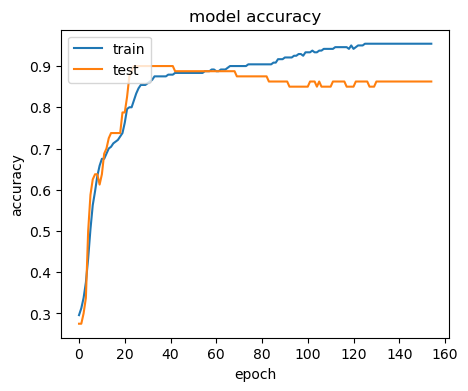

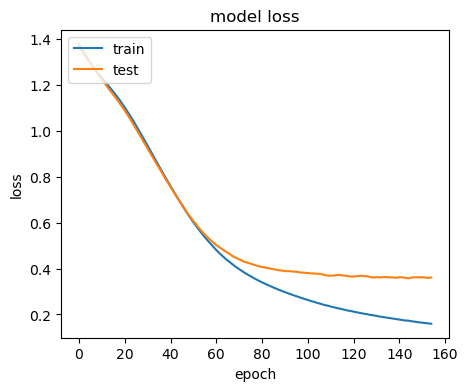

First layer: 16, Second layer: 64
[[20  0  0  0]
 [ 1 18  0  1]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


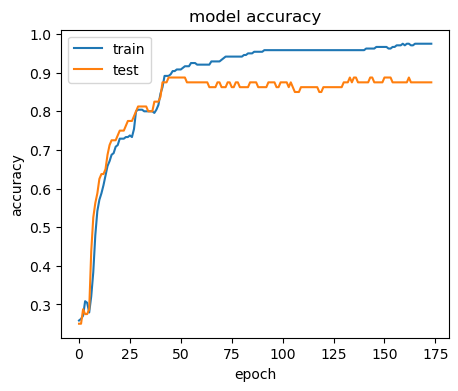

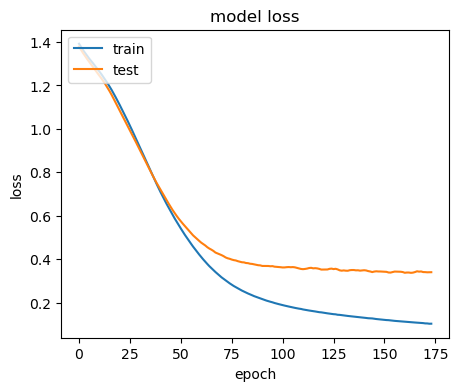

First layer: 16, Second layer: 128
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


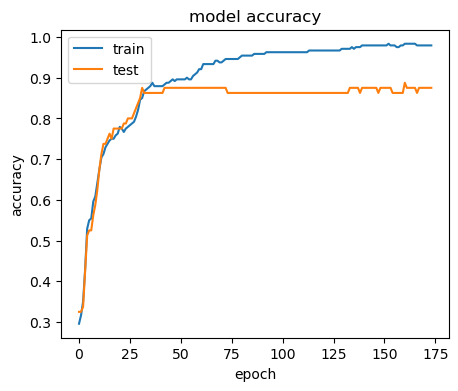

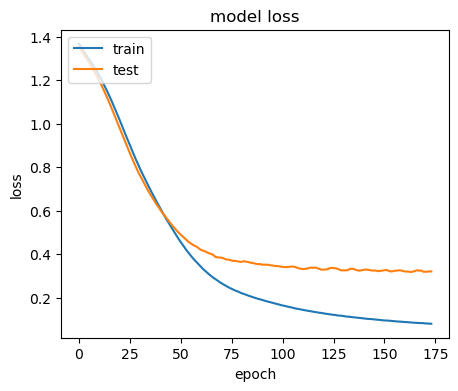

First layer: 16, Second layer: 256
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


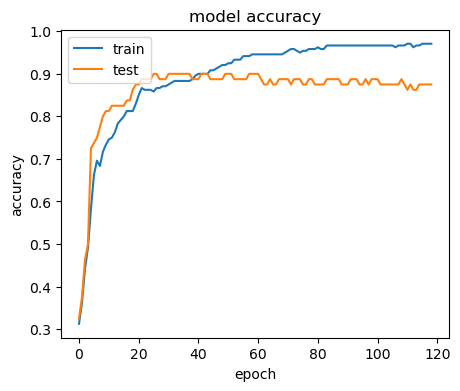

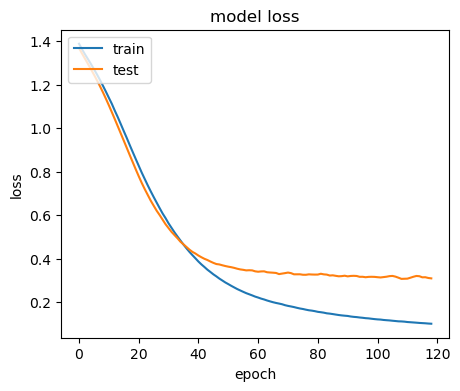

First layer: 16, Second layer: 512
[[19  0  0  1]
 [ 3 15  0  2]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.8625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


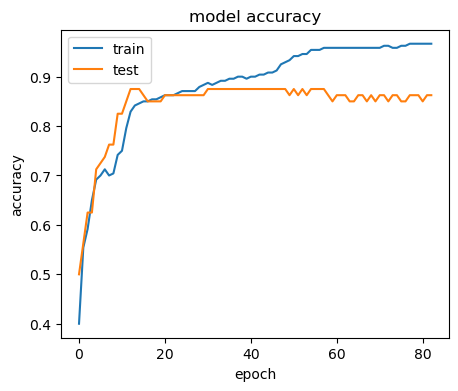

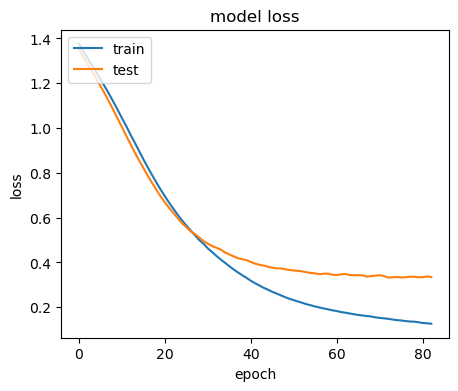

First layer: 32, Second layer: 8
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


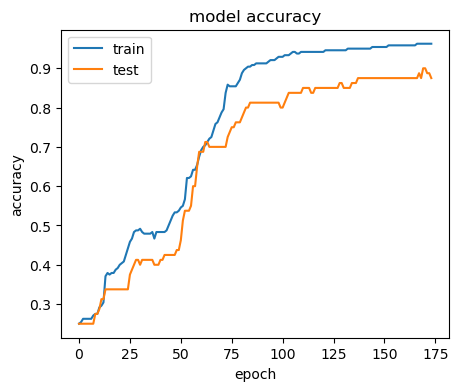

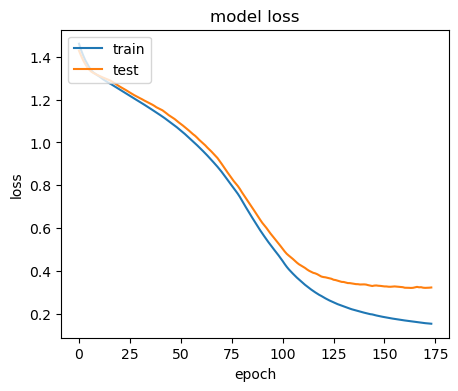

First layer: 32, Second layer: 16
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 3  0  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


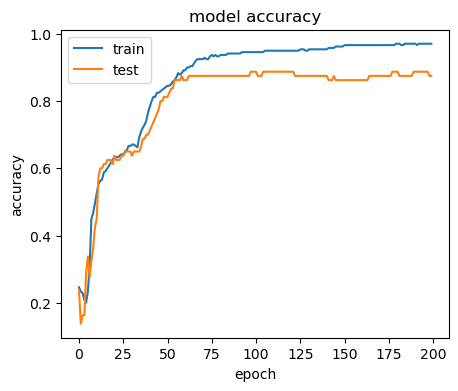

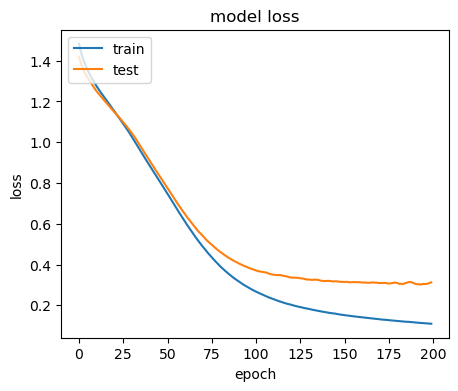

First layer: 32, Second layer: 32
[[19  0  0  1]
 [ 2 16  0  2]
 [ 0  3 17  0]
 [ 2  1  0 17]] 

The accuracy is 0.8625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


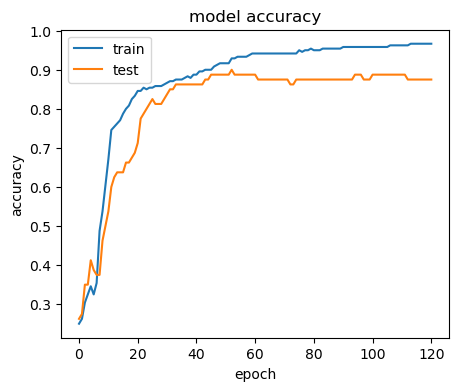

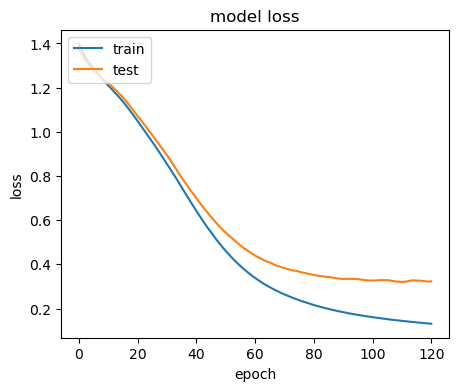

First layer: 32, Second layer: 64
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  1 19  0]
 [ 3  0  0 17]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


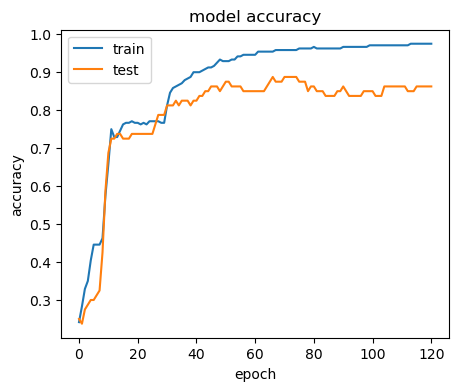

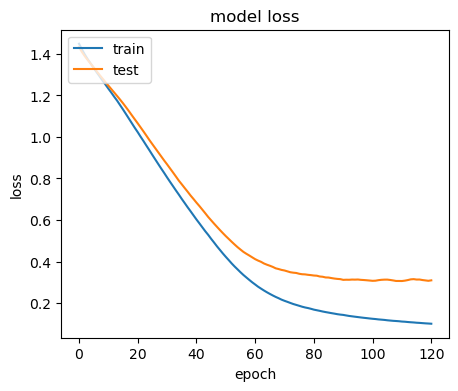

First layer: 32, Second layer: 128
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


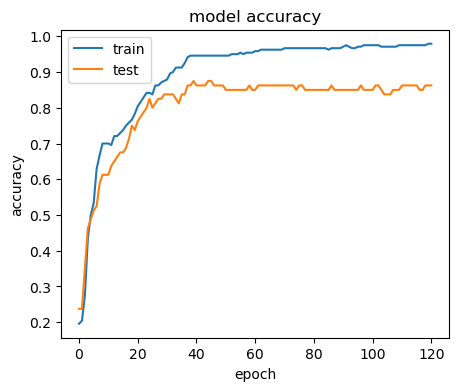

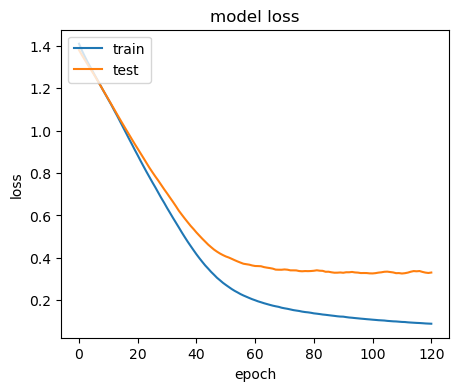

First layer: 32, Second layer: 256
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


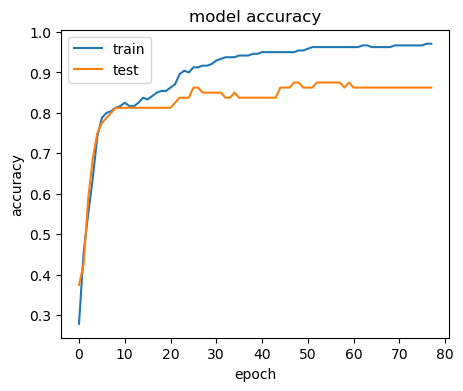

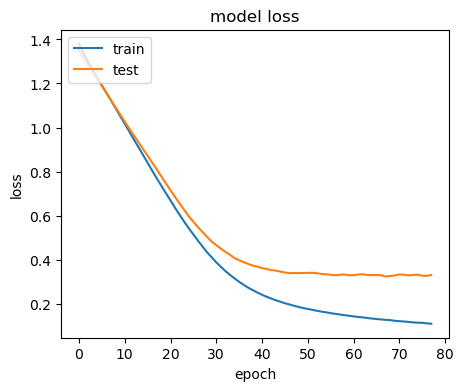

First layer: 32, Second layer: 512
[[19  0  0  1]
 [ 1 19  0  0]
 [ 0  3 17  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


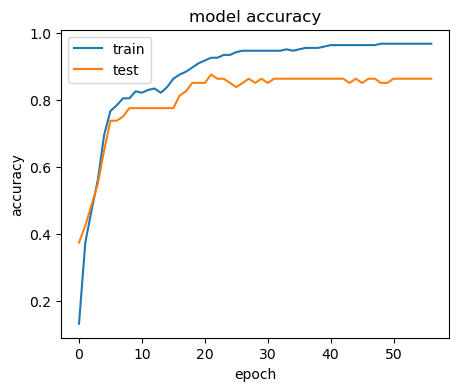

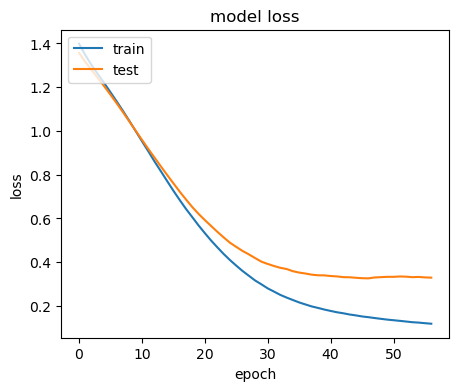

First layer: 64, Second layer: 8
[[20  0  0  0]
 [ 3 16  0  1]
 [ 0  2 18  0]
 [ 3  0  0 17]] 

The accuracy is 0.8875
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


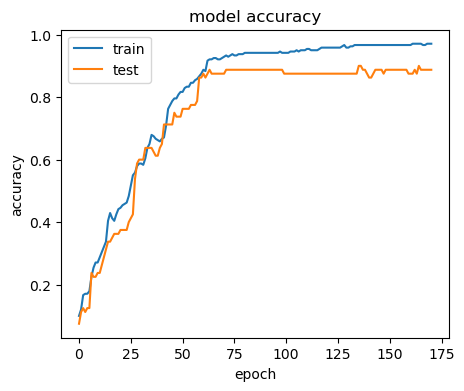

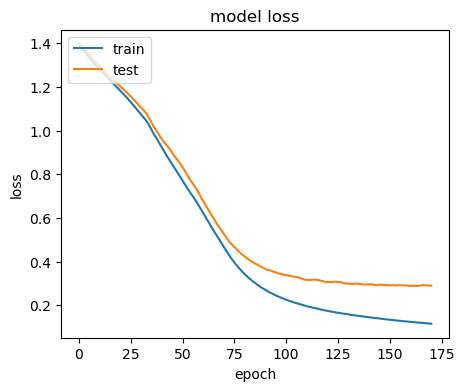

First layer: 64, Second layer: 16
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  3 17  0]
 [ 2  0  0 18]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


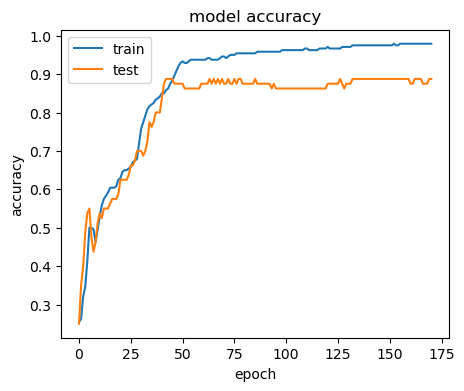

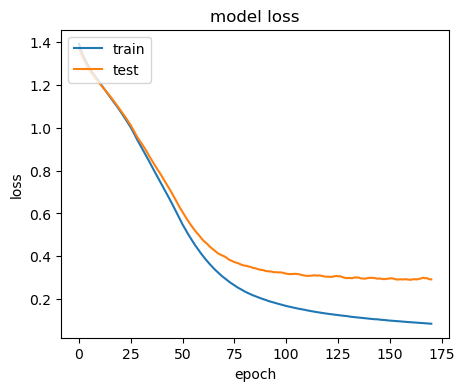

First layer: 64, Second layer: 32
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


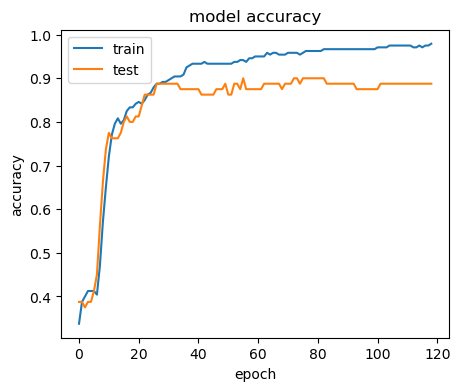

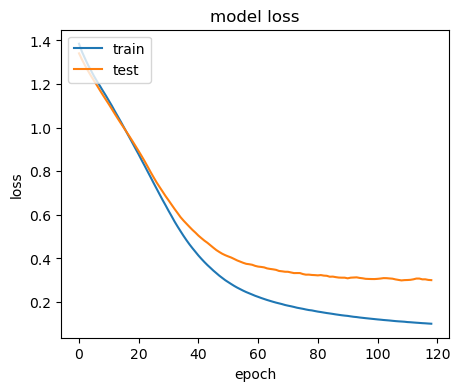

First layer: 64, Second layer: 64
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


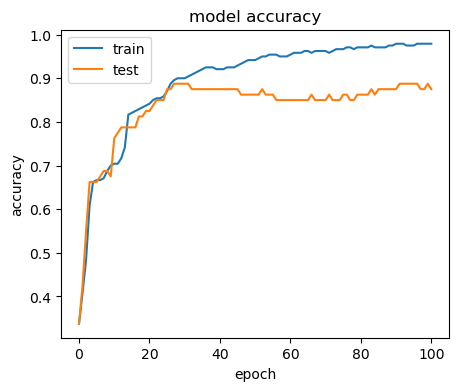

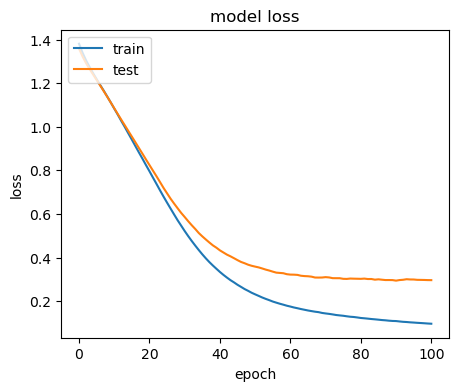

First layer: 64, Second layer: 128
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  1 19  0]
 [ 2  0  0 18]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


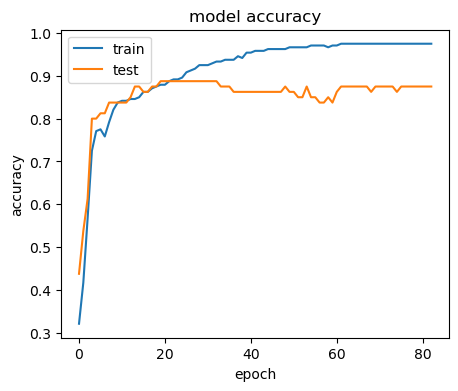

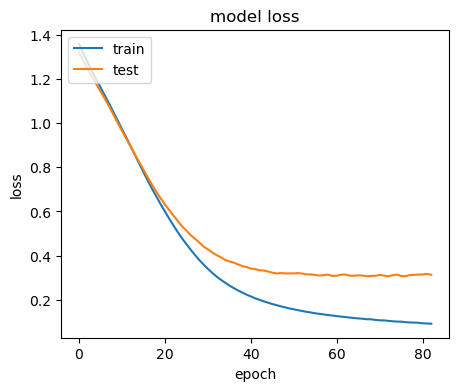

First layer: 64, Second layer: 256
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


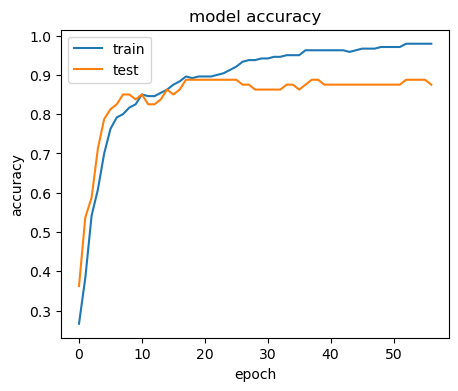

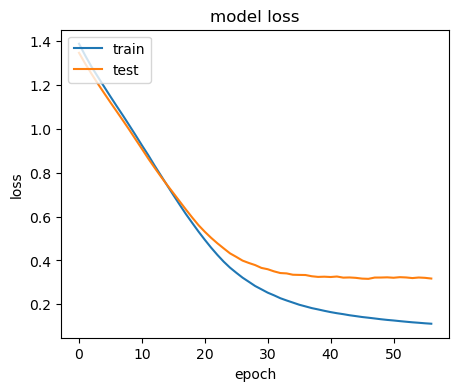

First layer: 64, Second layer: 512
[[20  0  0  0]
 [ 2 18  0  0]
 [ 0  1 19  0]
 [ 2  1  0 17]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


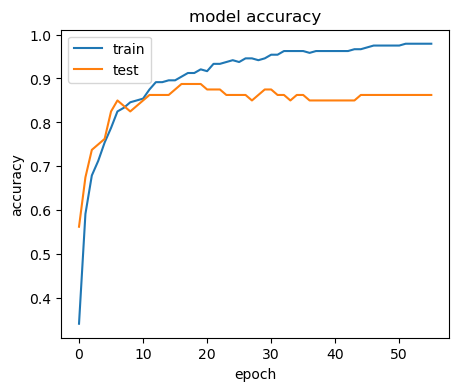

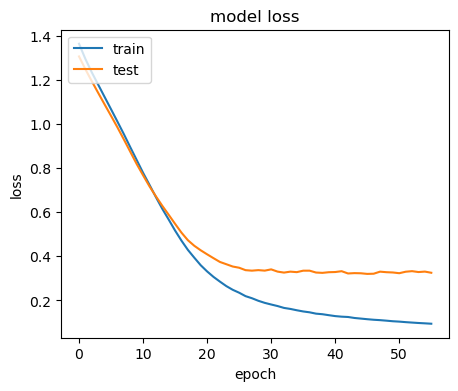

First layer: 128, Second layer: 8
[[20  0  0  0]
 [ 2 18  0  0]
 [ 0  2 18  0]
 [ 3  0  0 17]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


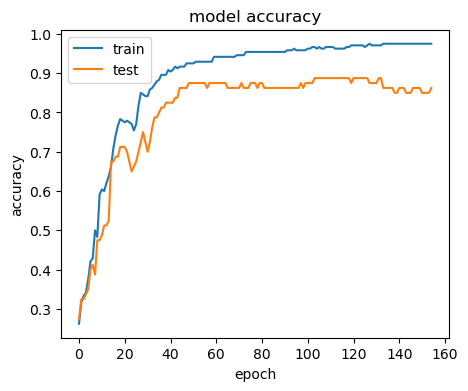

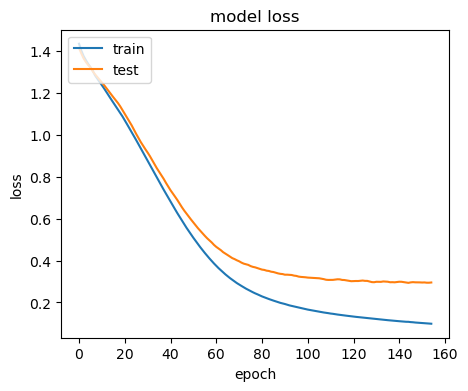

First layer: 128, Second layer: 16
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


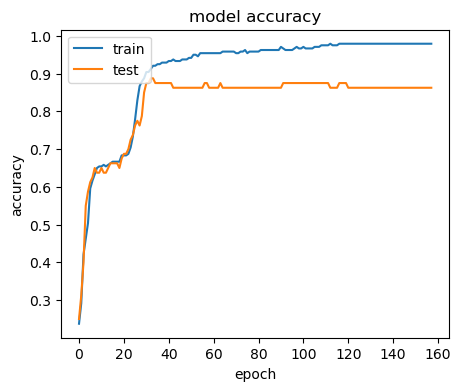

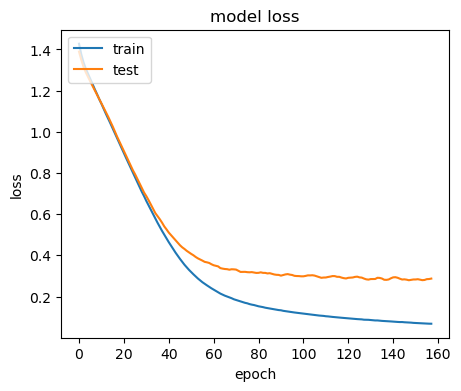

First layer: 128, Second layer: 32
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


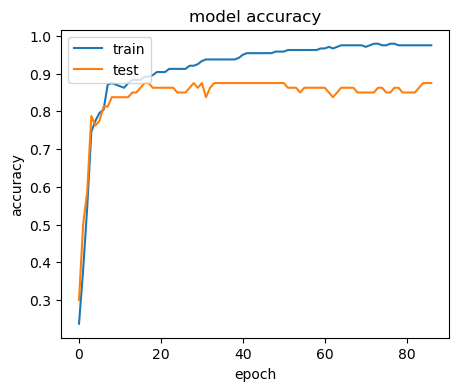

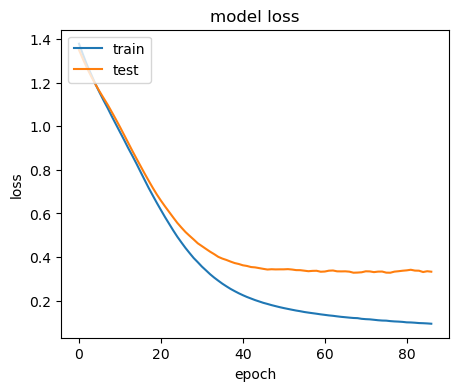

First layer: 128, Second layer: 64
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


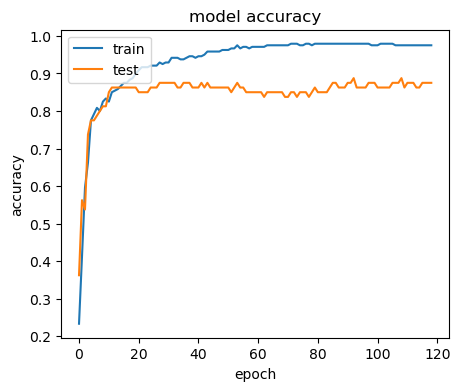

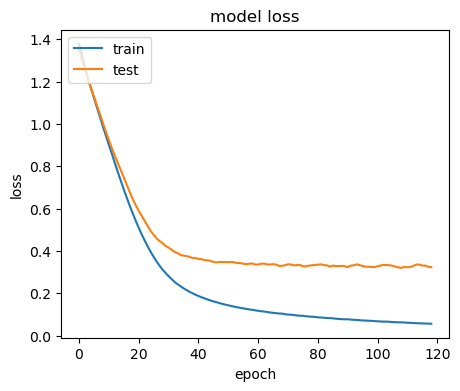

First layer: 128, Second layer: 128
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


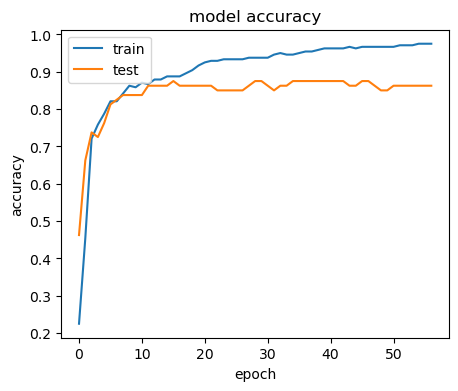

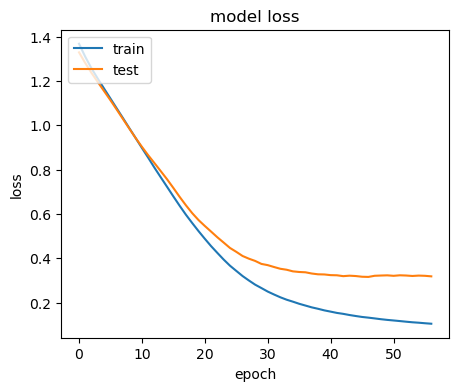

First layer: 128, Second layer: 256
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


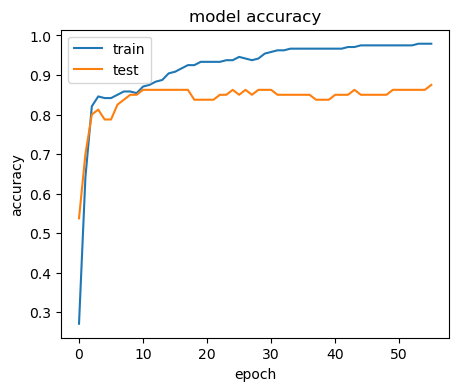

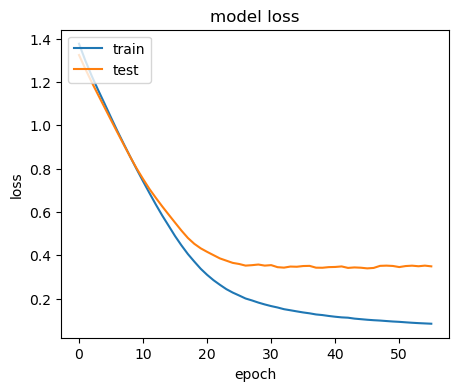

First layer: 128, Second layer: 512
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


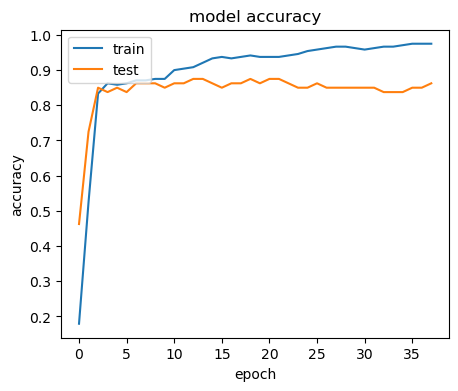

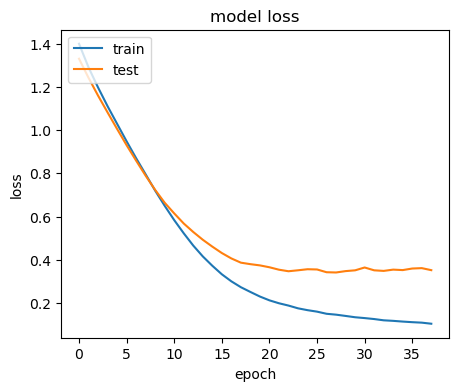

First layer: 256, Second layer: 8
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


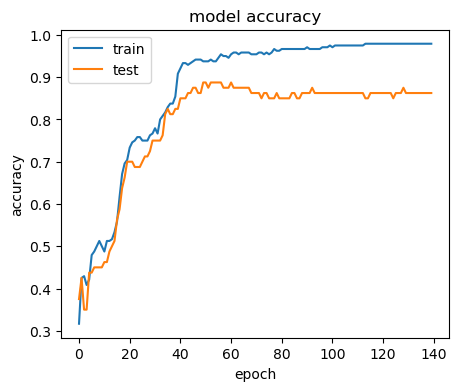

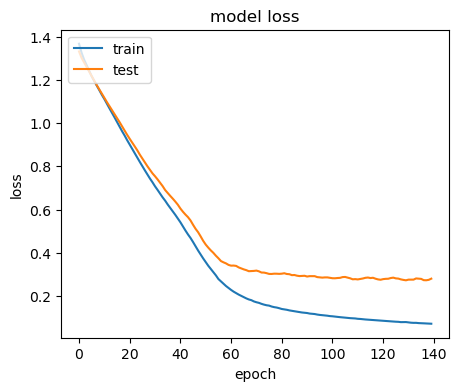

First layer: 256, Second layer: 16
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


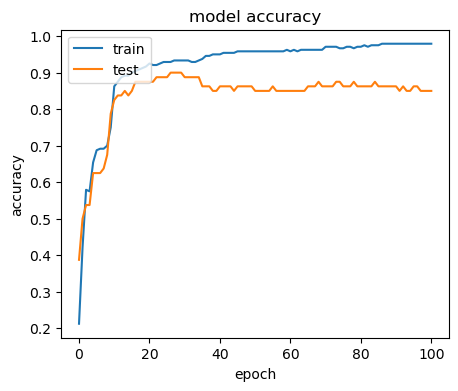

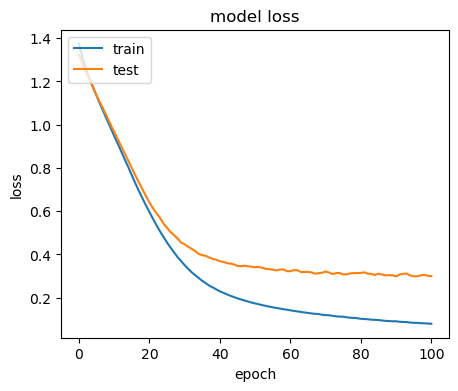

First layer: 256, Second layer: 32
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


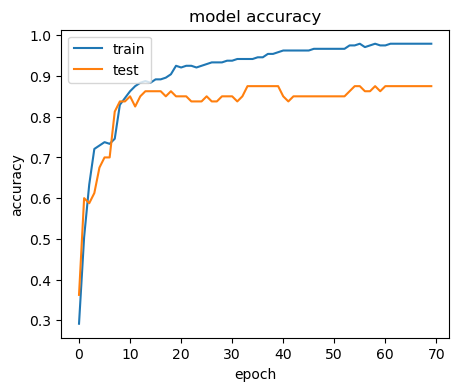

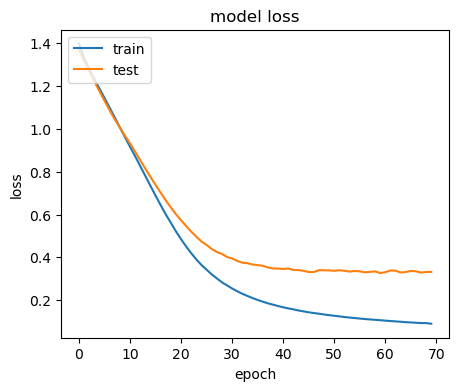

First layer: 256, Second layer: 64
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


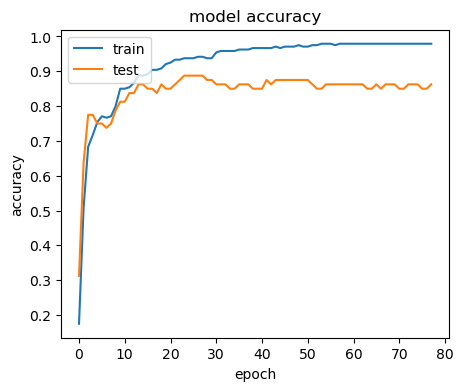

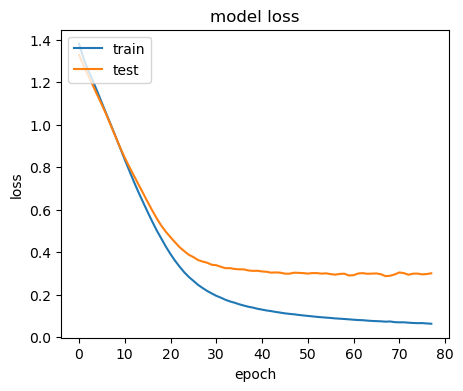

First layer: 256, Second layer: 128
[[20  0  0  0]
 [ 2 18  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


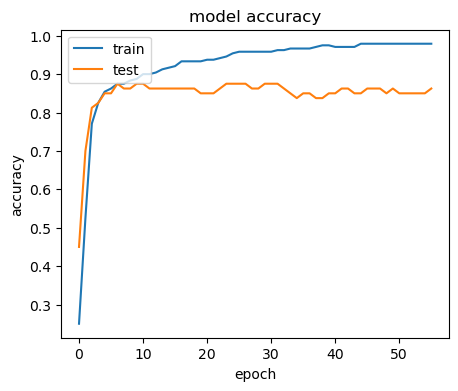

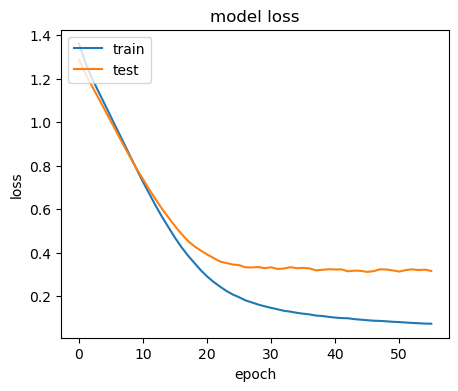

First layer: 256, Second layer: 256
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  1  0 17]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


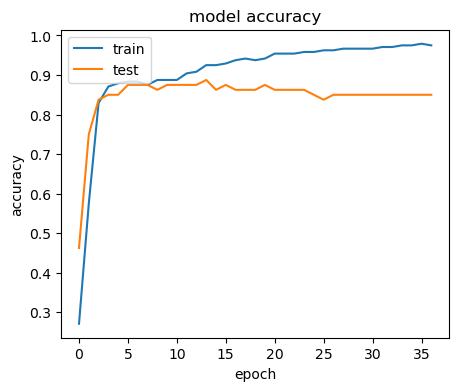

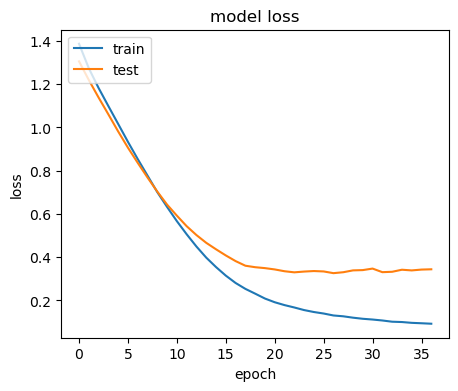

First layer: 256, Second layer: 512
[[19  0  0  1]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


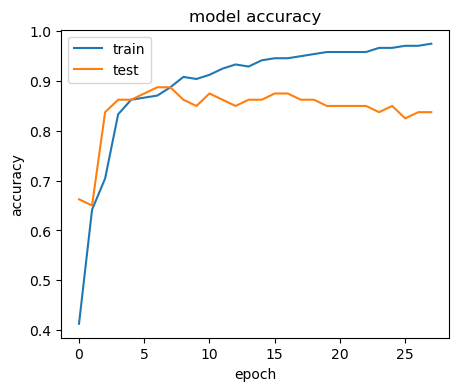

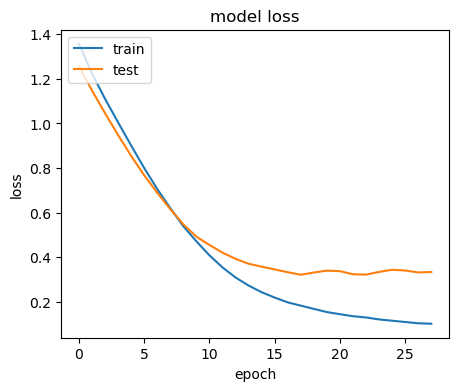

First layer: 512, Second layer: 8
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


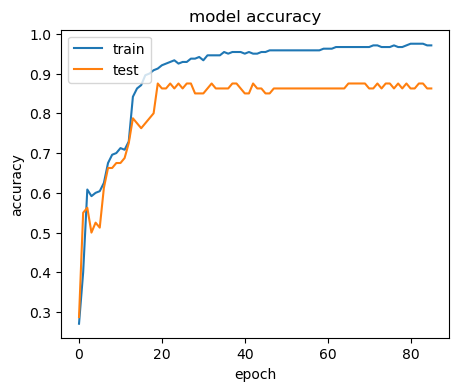

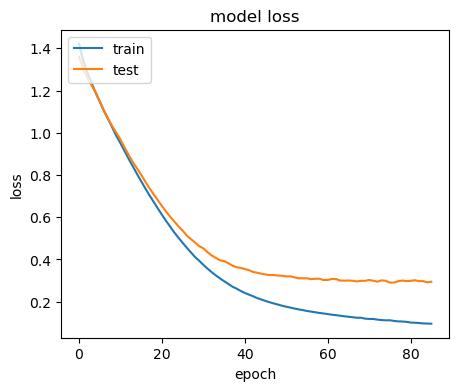

First layer: 512, Second layer: 16
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


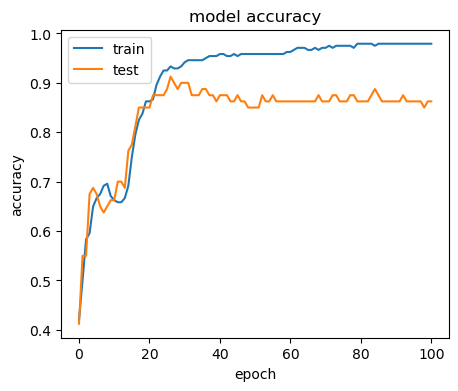

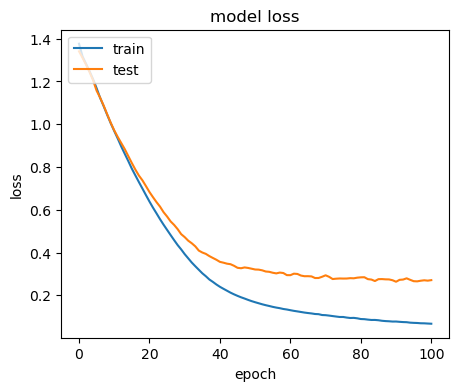

First layer: 512, Second layer: 32
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


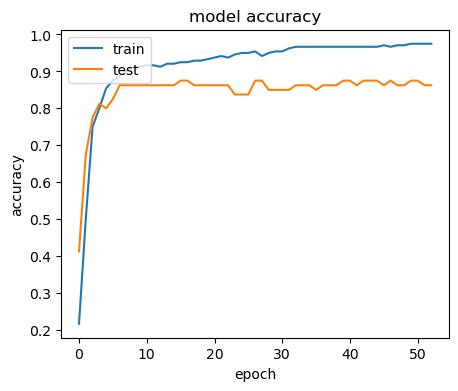

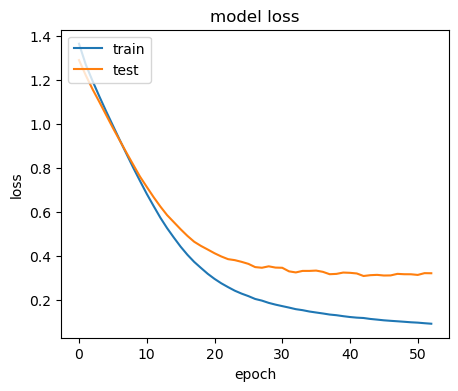

First layer: 512, Second layer: 64
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


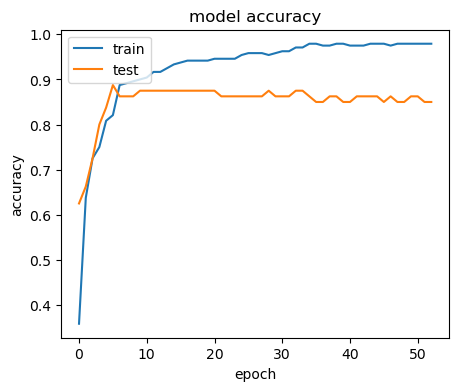

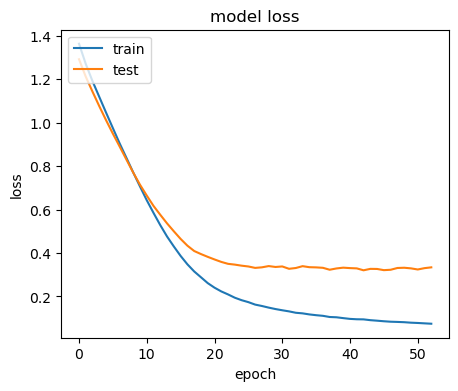

First layer: 512, Second layer: 128
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9375
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


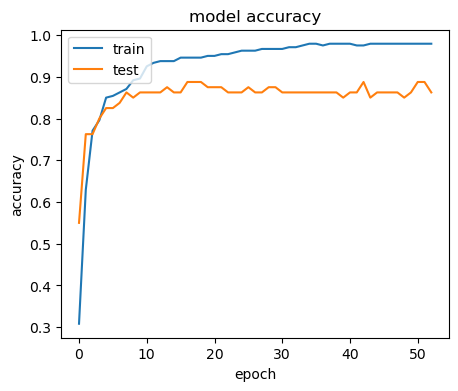

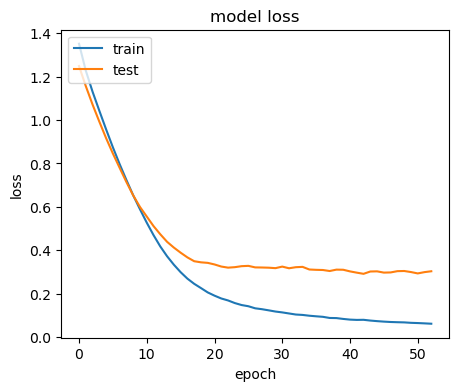

First layer: 512, Second layer: 256
[[20  0  0  0]
 [ 3 17  0  0]
 [ 0  2 18  0]
 [ 2  0  0 18]] 

The accuracy is 0.9125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


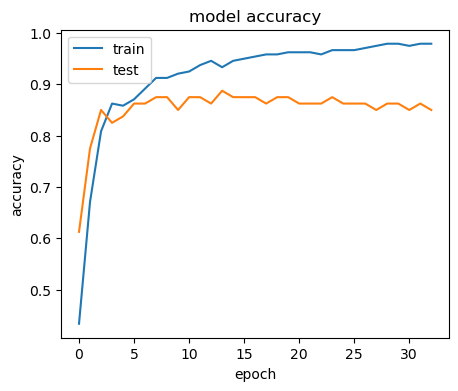

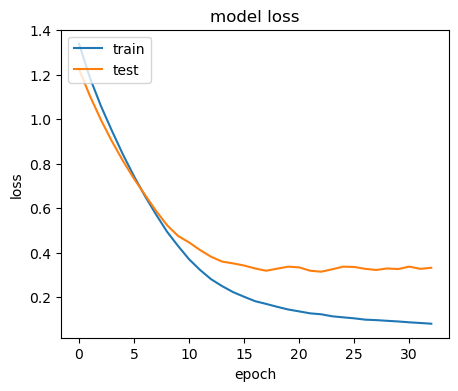

First layer: 512, Second layer: 512
[[20  0  0  0]
 [ 1 19  0  0]
 [ 0  3 17  0]
 [ 2  0  0 18]] 

The accuracy is 0.925
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


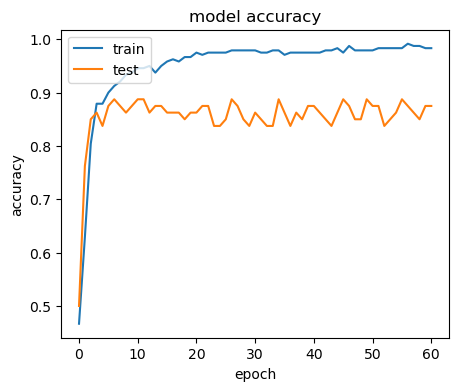

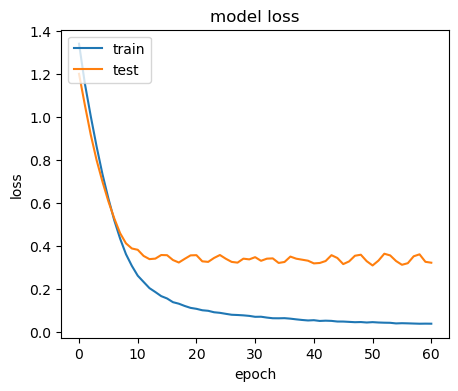

In [62]:
# num_of_neurons = [10, 20, 100, 150, 200, 250, 500, 1000]
num_of_neurons = [8, 16, 32, 64, 128, 256, 512]

for i in num_of_neurons:
    for j in num_of_neurons:
            print("First layer: {}, Second layer: {}".format(i, j))
            
            np.random.seed(42)
            random.seed(42)
            tf.random.set_seed(42)
            
            #Model building
            model = tf.keras.models.Sequential([
            tf.keras.layers.Input((21 * 2, )),
            tf.keras.layers.Dense(i, activation='relu'),
            tf.keras.layers.Dense(j, activation='relu'),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
            ])

            # Model compilation
            model.compile(
                optimizer = 'adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Model training
            history = model.fit(
                X_train, y_train,
                epochs = 200,
                batch_size=128,
                validation_data=(X_val, y_val),
                callbacks=[cp_callback, es_callback],
                verbose=0
            )

            # Evaluation
            Y_pred = model(X_test)
            y_pred = np.argmax(Y_pred, axis=1)
            confusionmat(y_test, y_pred)
            learningcurve(history)